# XGBoost regression models

## XGBoost regression theory

In machine learning, ensemble models perform better than individual models with high probability. An ensemble model combines different machine learning models into one. The Random Forest is a popular ensemble that takes the average of many Decision Trees via bagging. Bagging is short for “bootstrap aggregation”, meaning that samples are chosen with replacement (bootstrapping), and combined (aggregated) by taking their average.
Boosting is a strong alternative to bagging. Instead of aggregating predictions, boosters turn weak learners into strong learners by focusing on where the individual models (usually Decision Trees) went wrong. In Gradient Boosting, individual models train upon the residuals, the difference between the prediction and the actual results. 

[Gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting) is a machine learning technique for regression, classification and other tasks, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees When a decision tree is the weak learner, the resulting algorithm is called gradient boosted trees, which usually outperforms random forest. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

Instead of aggregating trees, gradient boosted trees learns from errors during each boosting round.
[XGBoost](https://en.wikipedia.org/wiki/XGBoost) is short for “eXtreme Gradient Boosting”. The “eXtreme” refers to speed enhancements such as parallel computing and cache awareness that makes XGBoost approximately 10 times faster than traditional Gradient Boosting. 

In addition, XGBoost includes a unique split-finding algorithm to optimize trees, along with built-in regularization that reduces overfitting. Generally speaking, XGBoost is a faster, more accurate version of Gradient Boosting.

Boosting performs better than bagging on average, and Gradient Boosting is arguably the best boosting ensemble. Since XGBoost is an advanced version of Gradient Boosting, and its results are unparalleled, it’s arguably the best machine learning ensemble that we have.

Below, an example of a tree obtained in this notebook is shown:

```{figure} ../media/images/tree-example.png
---
width: 600px
name: tree
---
This picture displays some leaves of a regression tree, where the input variables are the PCs of a regional predictor
```

In [1]:
# basics
import os, sys
import progressbar

# arrays
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.tree import plot_tree

# append sscode to path
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

# custom
from sscode.config import data_path
from sscode.data import Loader, load_moana_hindcast_ss, load_private_tgs
from sscode.pca import PCA_DynamicPred
from sscode.xgboost import XGBoost_Regression
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
from sscode.plotting.data import plot_uhslc_locations

# warnings
import warnings
warnings.filterwarnings('ignore')

# this is to allow plots to be centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Load the data (main + PCs)

As usual, we load the data that is going to be used, which are the predictor, the predictand, the validators in case we want to "validate" some results with the closest tidal gauges available, and the previously calculated regional pcs + gradient and time lapse=3, which means 2 days before the day at each time step.

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc'], plot=False
)


 loading the sea-level-pressure fields... 


 loading daily resampled data... 


 loading the Moana v2 hindcast data... 


 loading and plotting the UHSLC tidal guages... 



In [3]:
# load / calculate the pcs
if os.path.isfile('../data/cfsr/cfsr_regional_gradient_tl3_daily_pcs.nc'):
    pcs_cfsr = xr.open_dataset(
        '../data/cfsr/cfsr_regional_gradient_tl3_daily_pcs.nc'
    )
    # from sscode.plotting.pca import plot_pcs
    # plot_pcs(pcs_cfsr,n_plot=1)
else:
    # calculate the pcs
    pcs_cfsr, pcs_scaler = PCA_DynamicPred(
        load_cfsr_moana_uhslc.predictor_slp,
        calculate_gradient=True,
        time_lapse=3,time_resample='1D',
        pca_plot=(False,False,2)
    )

## XGBoost regression with regional predictor

In the following cell, a XGBoost regression is performed over all the domain of the Moana v2 hindcast nearshore, having the regional pcs (slp + gradient) as the predictor. Moreover, we plot the obtained results, which are also saved in our `data/statistics` folder, with the name `stats_xgboost_regional_daily.nc`.

```{note}
As it can be seen in the results plot, the different shores in New Zealand show very different results
```

In [4]:
run = False
if run:
    # perform the XGBoost-Regression (regional)
    metrics_regional = [] # save regional metrics
    pcs_to_use_regional = [] # save used pcs 
    sites_regional = np.arange(
        0,len(load_cfsr_moana_uhslc.predictand.site.values),1
    ) # select here the desired sites to apply linreg
    # perform the XGBoost regression over all the sites
    for site in progressbar.progressbar(sites_regional):
        ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=site)\
            .load().resample(time='1D').max()
        metrics, model, pcs_to_use = XGBoost_Regression(
            pcs_cfsr, ss_moana
        ) # using the regional-pre-loaded pcs
        metrics_regional.append(list(metrics.values())) # save site metrics
        pcs_to_use_regional.append(pcs_to_use) # save used pcs
    # now, save all in xarray.Dataset
    sites_metrics_regional = {}
    for im,metric in enumerate(metrics.keys()):
        sites_metrics_regional[metric] = (('station'),np.array(metrics_regional)[:,im])
    sites_metrics_regional['latitude'] = (
        ('station'),load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lat.values
    )
    sites_metrics_regional['longitude'] = (
        ('station'),load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lon.values
    )
    # save the metrics
    metrics_dataset_regional = xr.Dataset(
        sites_metrics_regional,coords={'station':sites_regional}
    )
    # local copys
    if False:
        metrics_dataset_regional.to_netcdf(
            data_path+'/statistics/models/stats_xgboost_regional_daily_new.nc'
        ) # save metrics in all the stations
        np.save(
            data_path+'/statistics/models/pcs_xgboost_regional_daily_new.npy',
            np.array(pcs_to_use_regional)
        ) # save pcs used in the linear regressions
else:
    metrics_dataset_regional = xr.open_dataset(
        data_path+'/statistics/models/stats_xgboost_regional_daily.nc'
    )

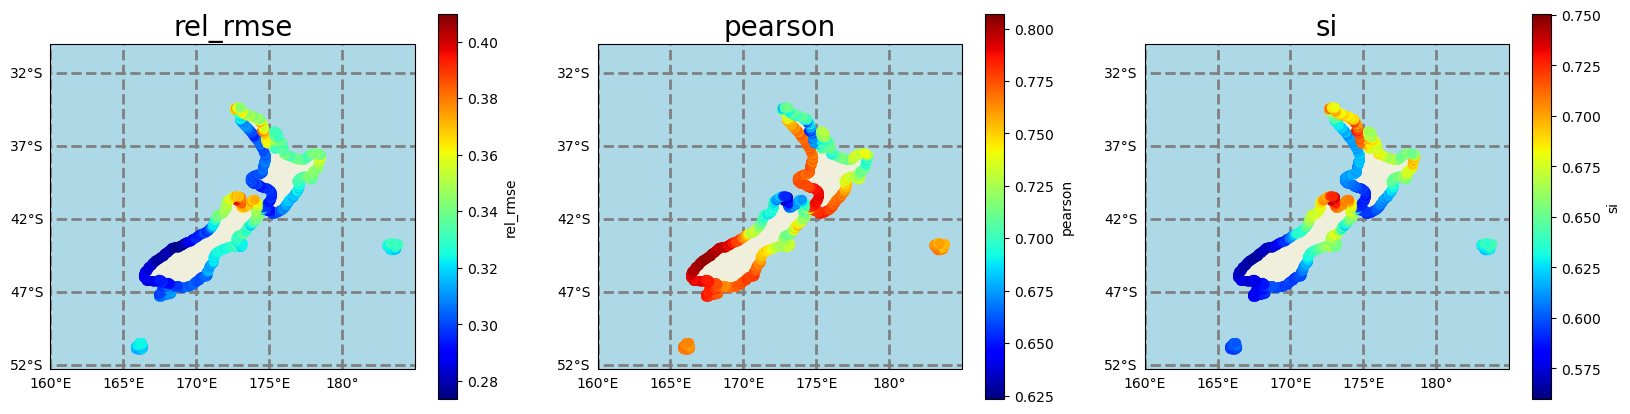

In [5]:
# plot results
if True:
    from sscode.plotting.validation import plot_stats
    plot_stats(metrics_dataset_regional,plot_stats=['rel_rmse','pearson','si'])

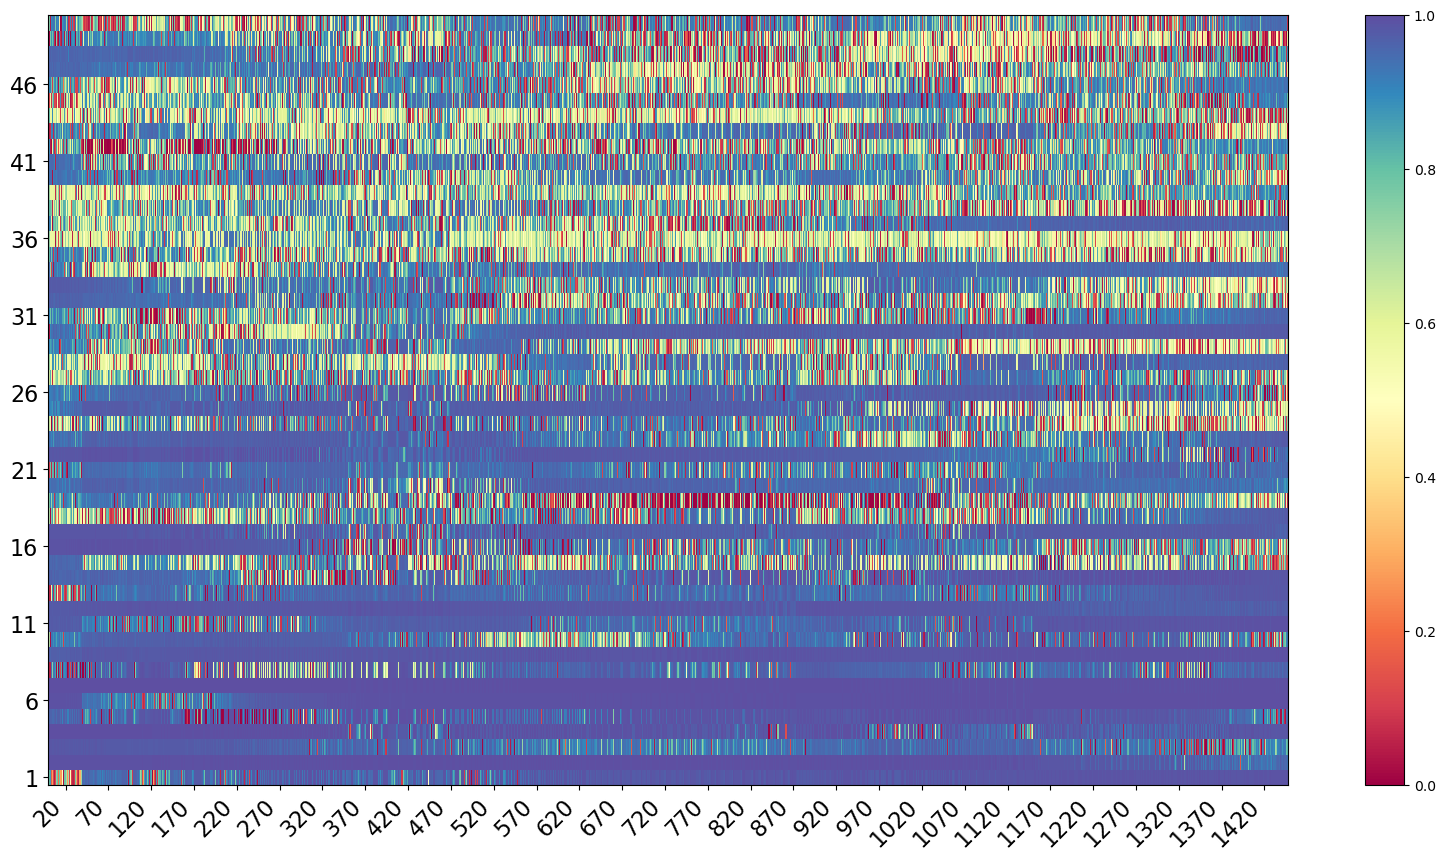

In [6]:
pcs_to_use_regional = np.load(
    data_path+'/statistics/models/pcs_xgboost_regional_daily.npy',
    allow_pickle=True
)
max_pcs = max([np.max(array) for array in pcs_to_use_regional])
pcs_importance = np.zeros((len(pcs_to_use_regional),max_pcs))
for i,array in enumerate(pcs_to_use_regional):
    for pc in range(max_pcs):
        try:
            pcs_importance[i,pc] = (max_pcs-np.where(array[::-1]==pc)[0])/max_pcs
        except:
            continue
fig, ax = plt.subplots(figsize=(20,10))
pcol = ax.pcolor(pcs_importance.T[:50,:],cmap='Spectral')
fig.colorbar(pcol)
ax.set_yticks(np.arange(0,50,5)+0.5)
ax.set_yticklabels(np.arange(0,50,5)+1,fontsize=16)
ax.set_xticks(np.arange(20,len(pcs_to_use_regional))[::50]+0.5)
ax.set_xticklabels(np.arange(
    20,len(load_cfsr_moana_uhslc.predictand.site.values),1
)[::50],fontsize=16)
plt.setp(ax.get_xticklabels(),rotation=45,ha='right')
plt.show()

### XGBoost regression in the UHSLC tidal gauges + validation

This part explanation is similar to the one available at **MultiLinear regression models (models_linear.ipynb)** and **KNN regressor models (models_knn.ipynb)**!!

But in this case, we will also use the trained agent to see what are the best parameters for our XGBoost model, in all the locations of the tidal gauges, but training the model with the Moana v2 hindcast.

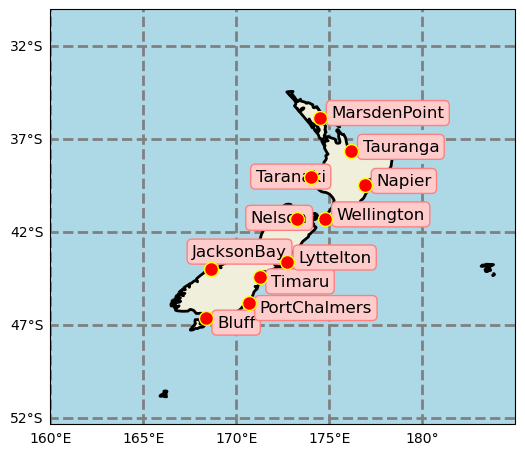

In [7]:
# plot the uhslc tidal-gauges locations
plot_uhslc_locations(load_cfsr_moana_uhslc.validator)


 90 PCs (0.8 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': [50], 'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_samples_split': array([0.02      , 0.03111111, 0.04222222, 0.05333333, 0.06444444,
       0.07555556, 0.08666667, 0.09777778, 0.10888889, 0.12      ]), 'learning_rate': [0.1], 'loss': ['ls']} grid parameters... 

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 best model fitted with {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 9, 'min_samples_split': 0.06444444444444444, 'n_estimators': 50} parameters!! 



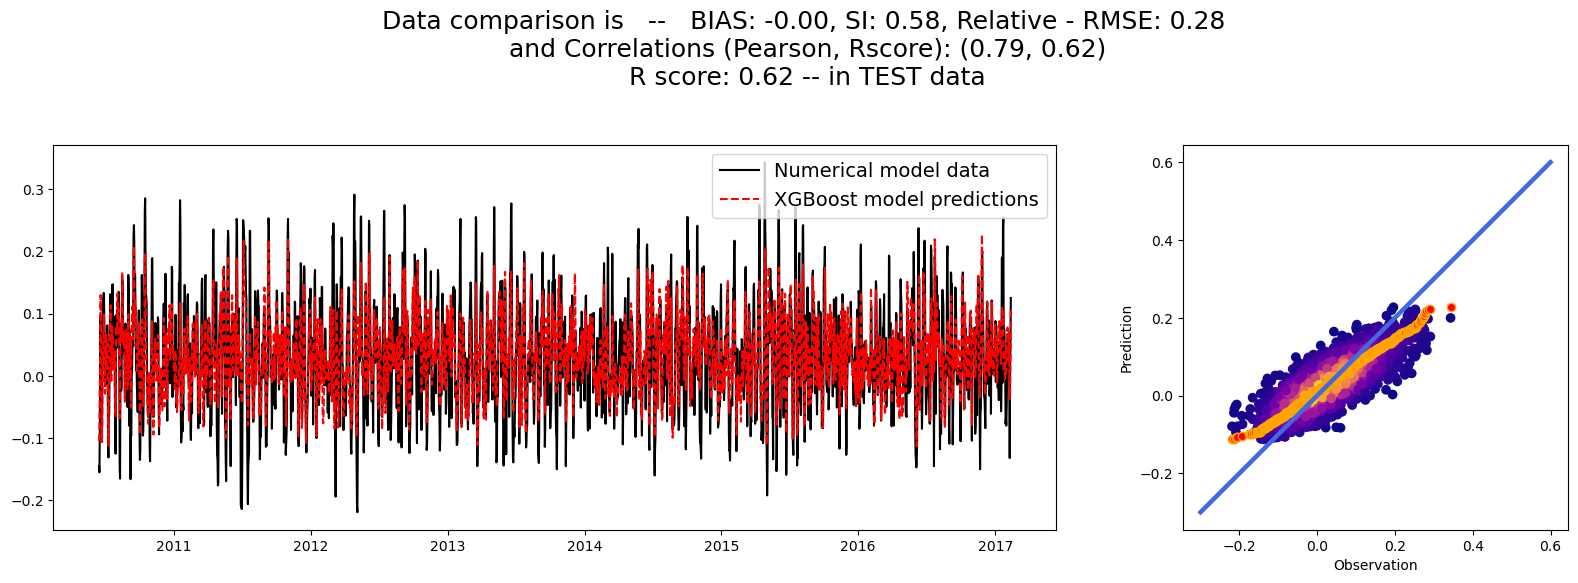

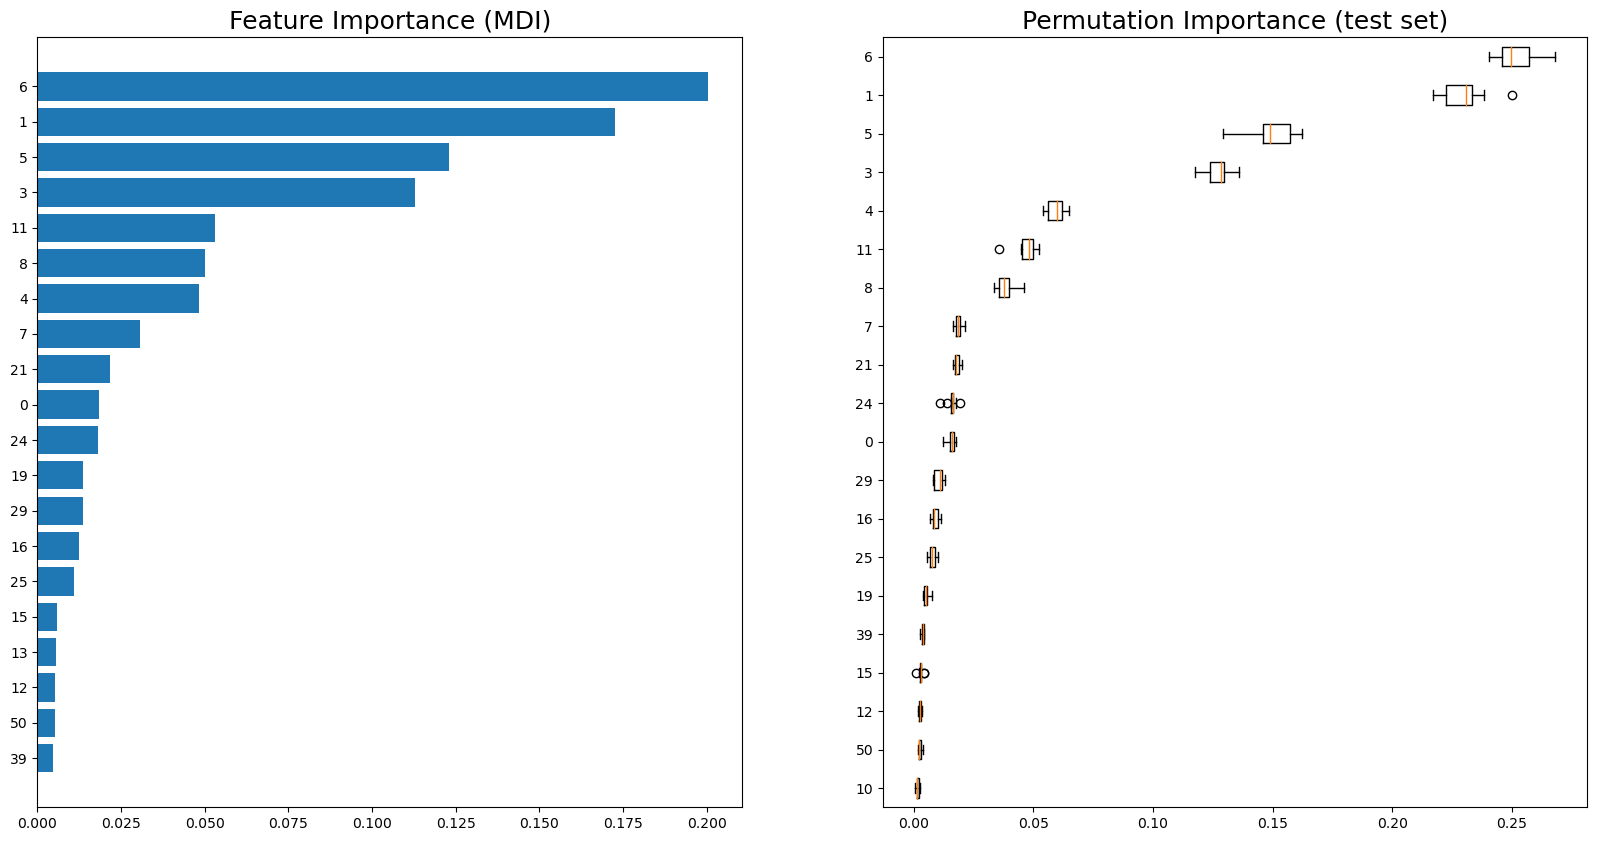

Data comparison is   --   BIAS: -0.00, SI: 0.58, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.79, 0.62)
 R score: 0.62 -- in TEST data


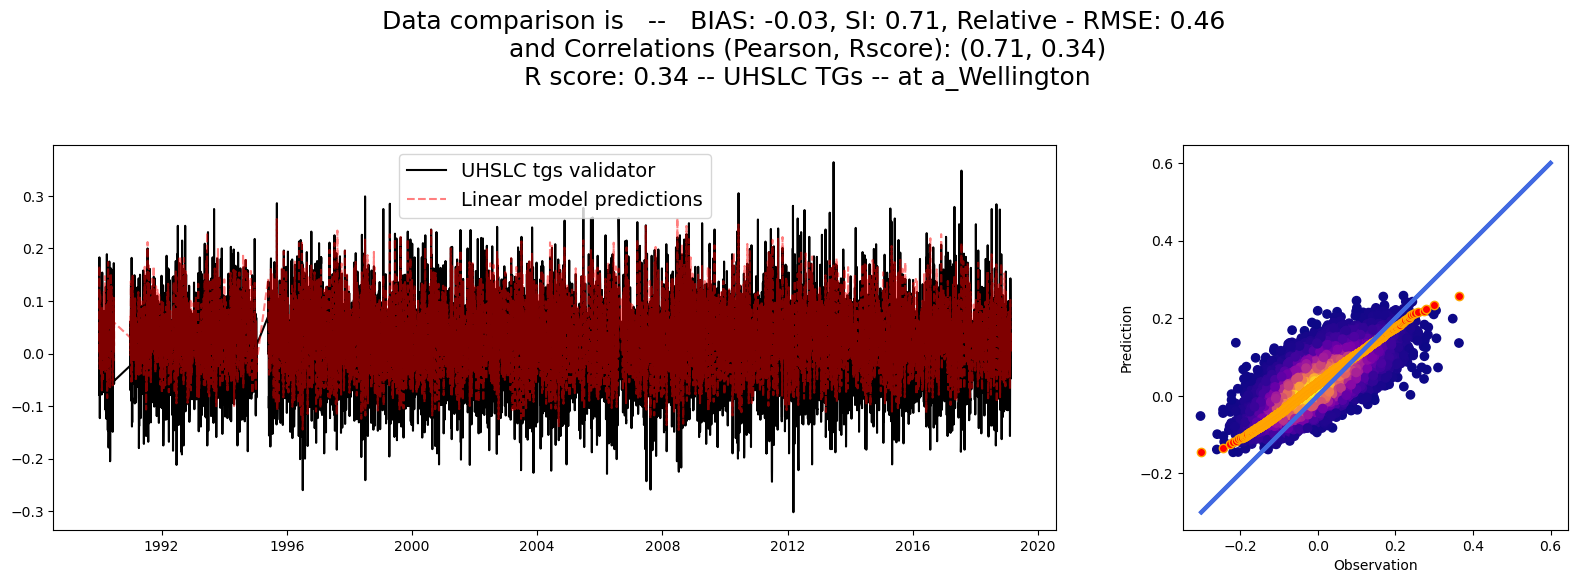


 90 PCs (0.8 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': [50], 'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_samples_split': array([0.02      , 0.03111111, 0.04222222, 0.05333333, 0.06444444,
       0.07555556, 0.08666667, 0.09777778, 0.10888889, 0.12      ]), 'learning_rate': [0.1], 'loss': ['ls']} grid parameters... 

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 best model fitted with {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 11, 'min_samples_split': 0.07555555555555556, 'n_estimators': 50} parameters!! 



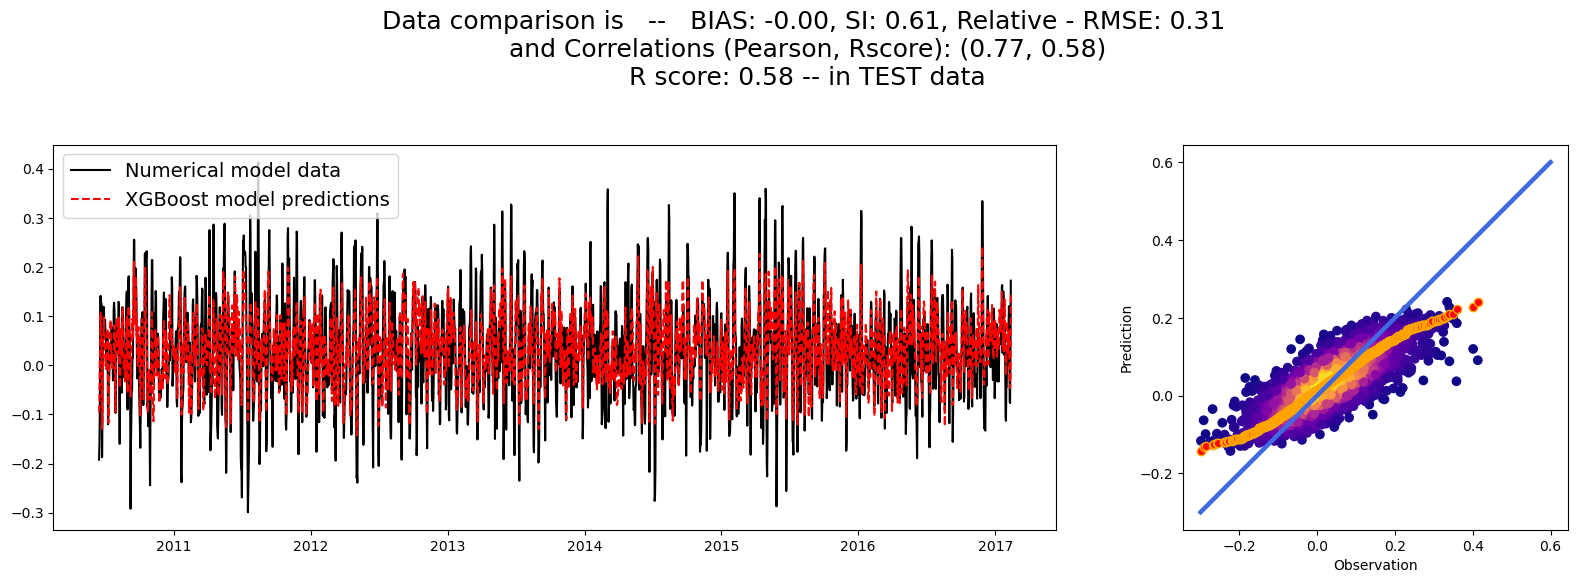

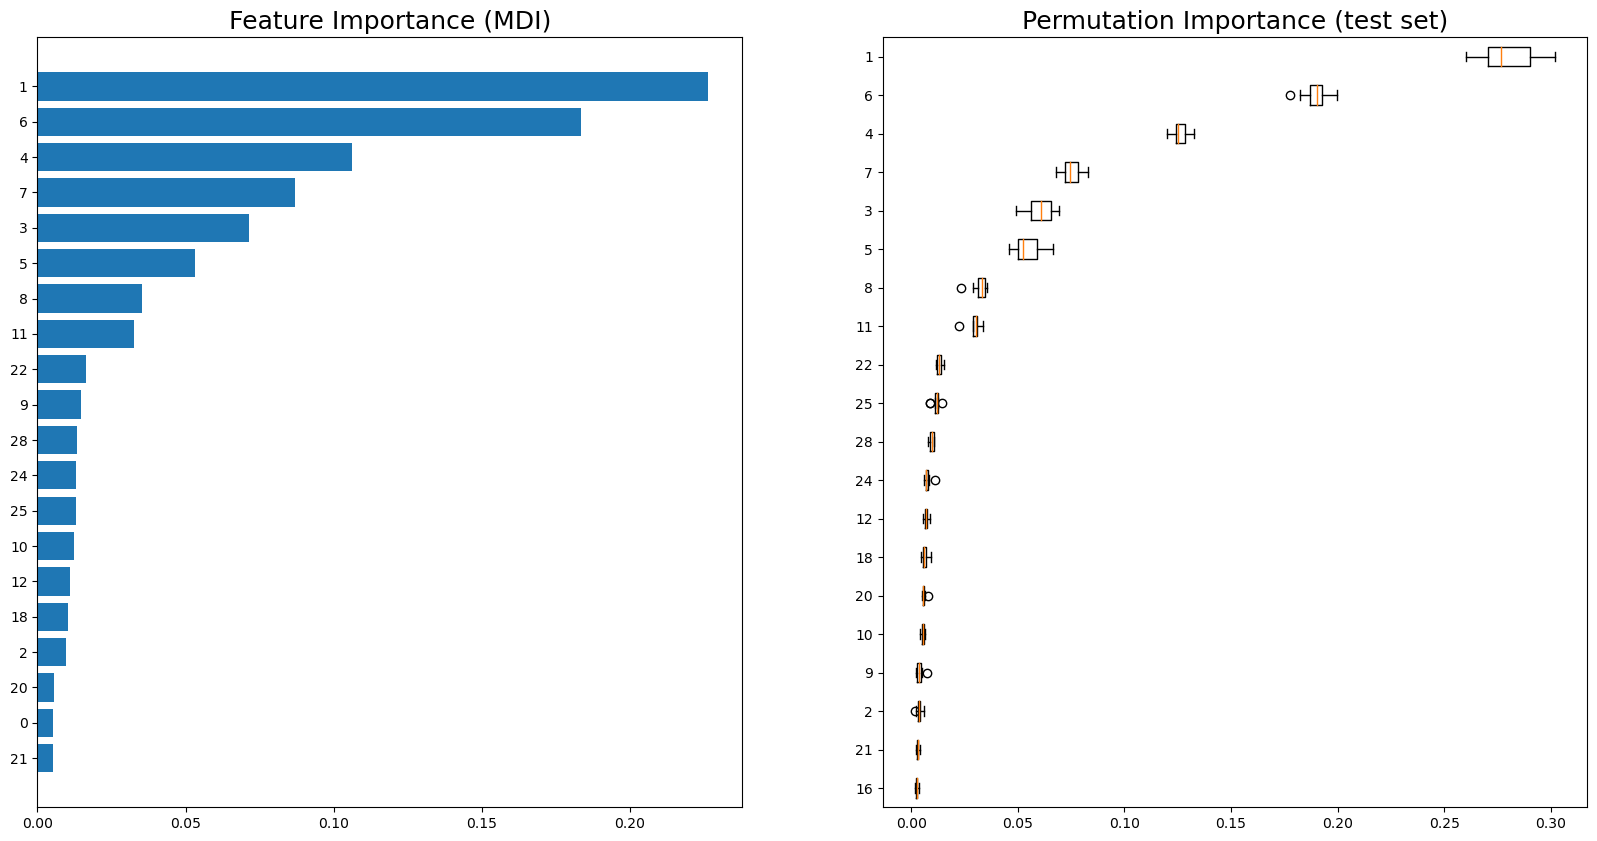

Data comparison is   --   BIAS: -0.00, SI: 0.61, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.77, 0.58)
 R score: 0.58 -- in TEST data


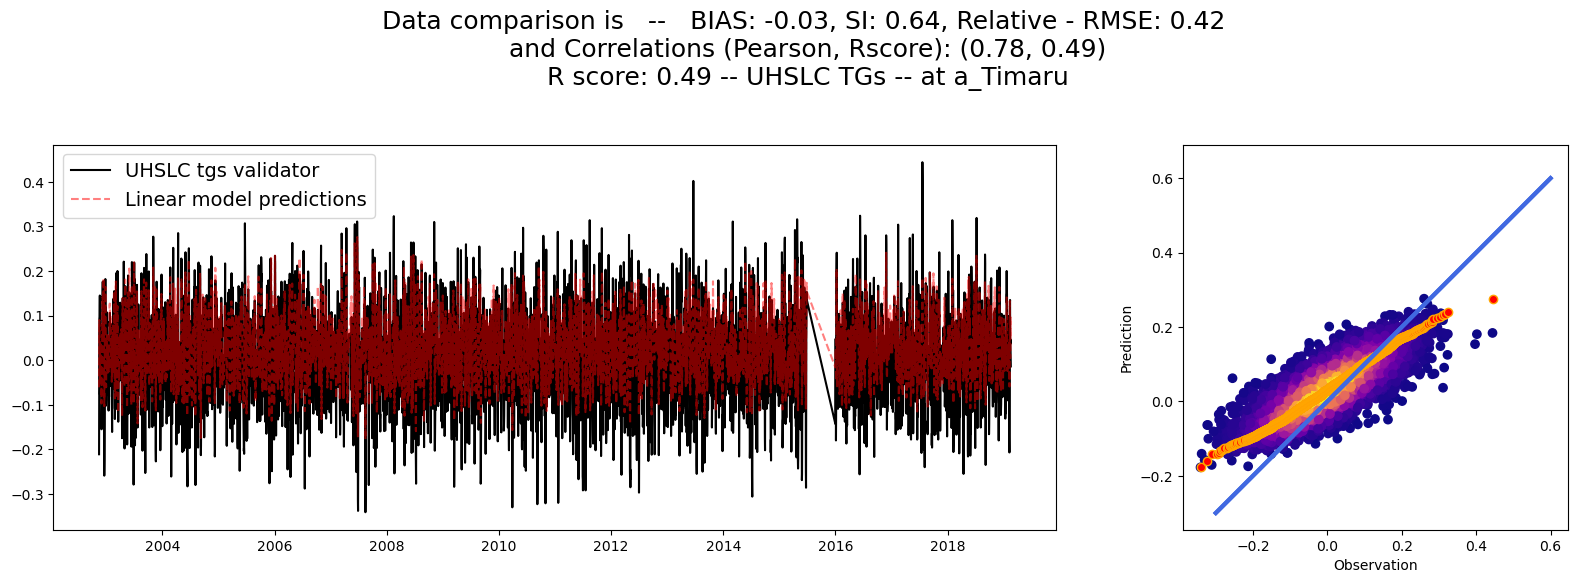


 90 PCs (0.8 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': [50], 'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_samples_split': array([0.02      , 0.03111111, 0.04222222, 0.05333333, 0.06444444,
       0.07555556, 0.08666667, 0.09777778, 0.10888889, 0.12      ]), 'learning_rate': [0.1], 'loss': ['ls']} grid parameters... 

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 best model fitted with {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 12, 'min_samples_split': 0.05333333333333333, 'n_estimators': 50} parameters!! 



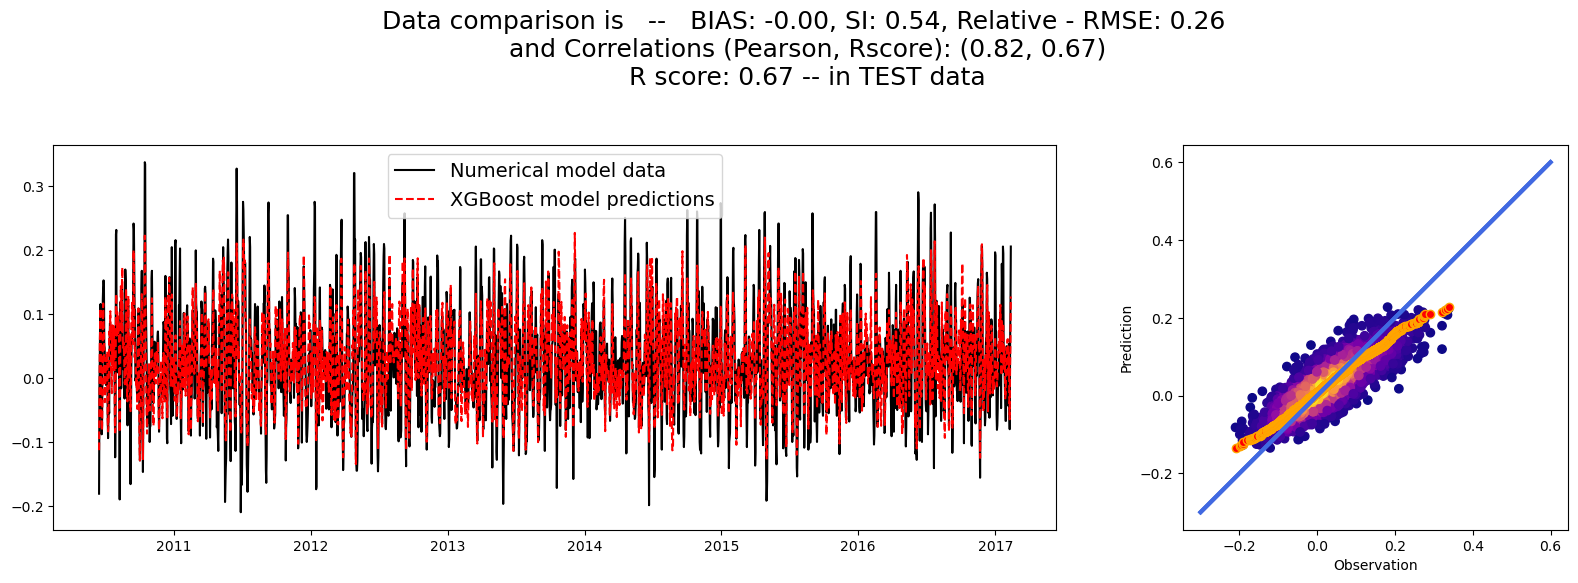

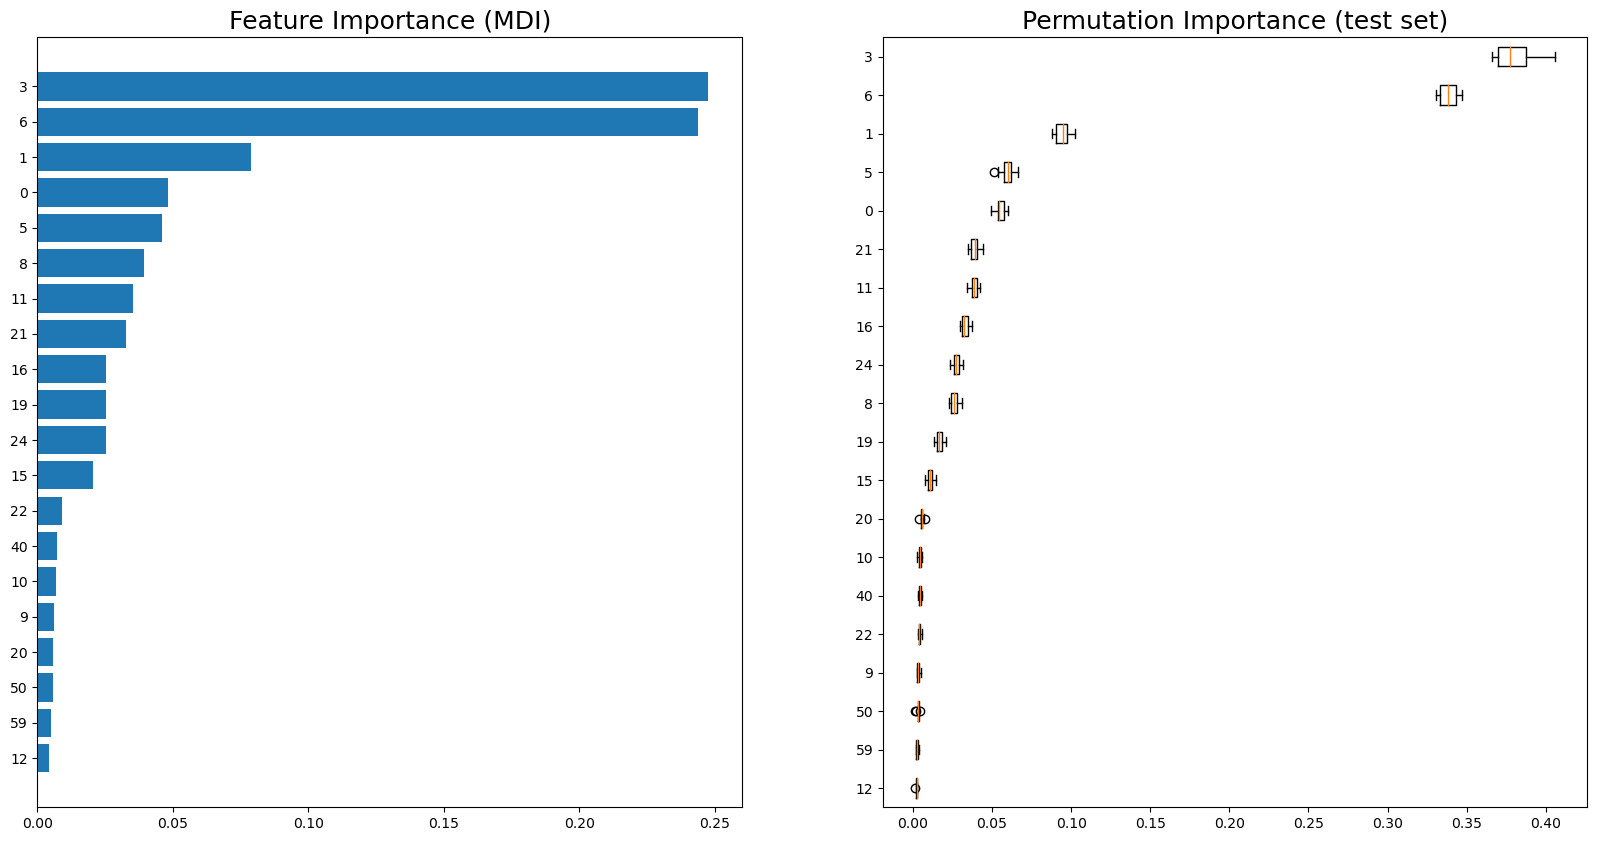

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 R score: 0.67 -- in TEST data


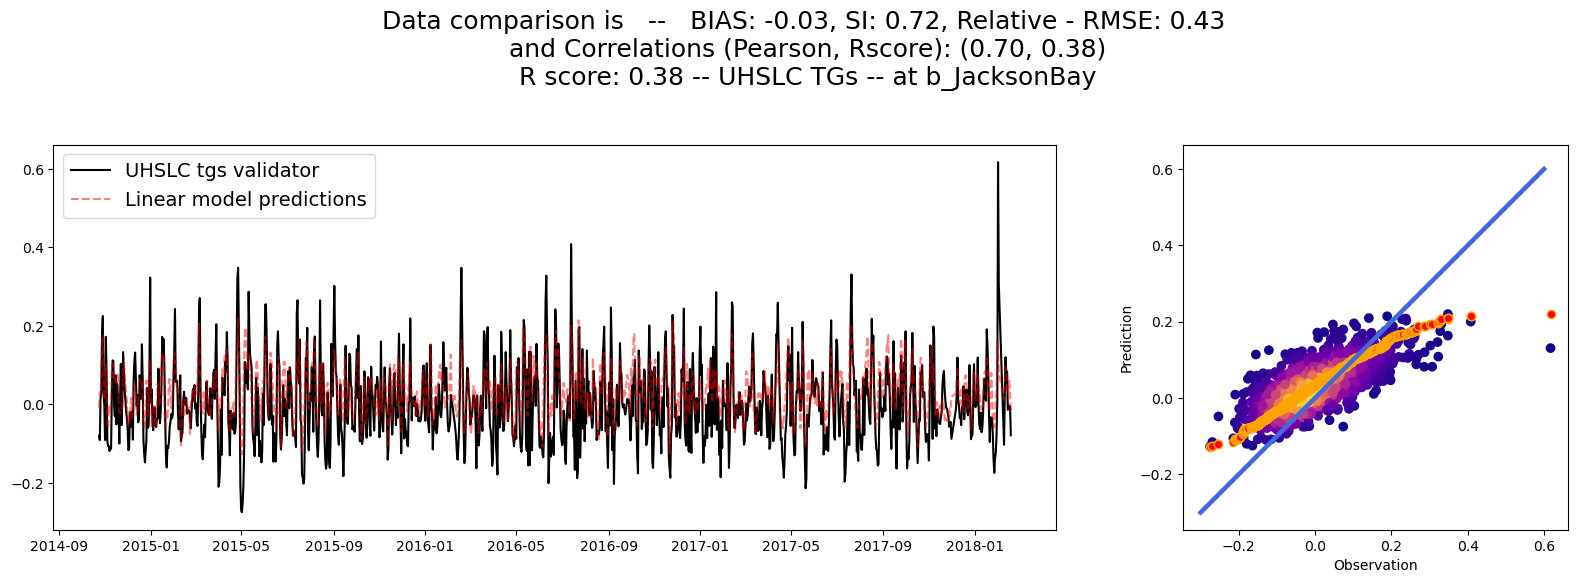


 90 PCs (0.8 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': [50], 'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_samples_split': array([0.02      , 0.03111111, 0.04222222, 0.05333333, 0.06444444,
       0.07555556, 0.08666667, 0.09777778, 0.10888889, 0.12      ]), 'learning_rate': [0.1], 'loss': ['ls']} grid parameters... 

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 best model fitted with {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 8, 'min_samples_split': 0.04222222222222222, 'n_estimators': 50} parameters!! 



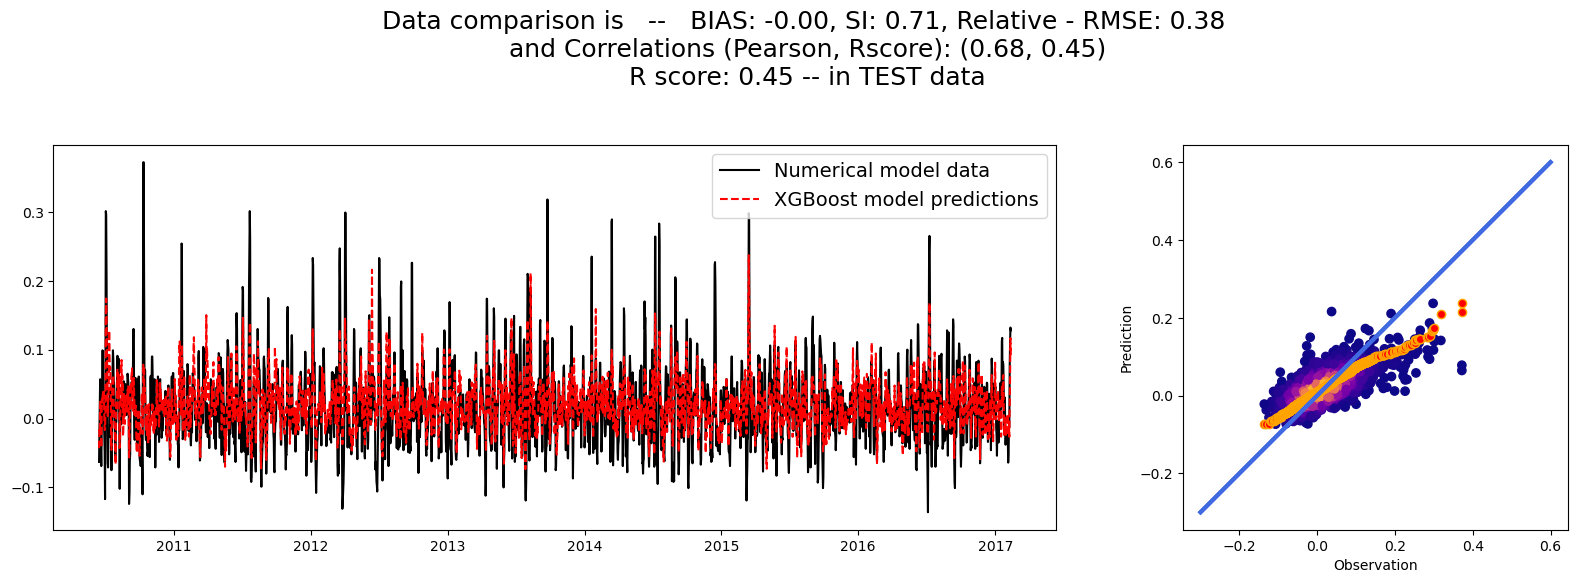

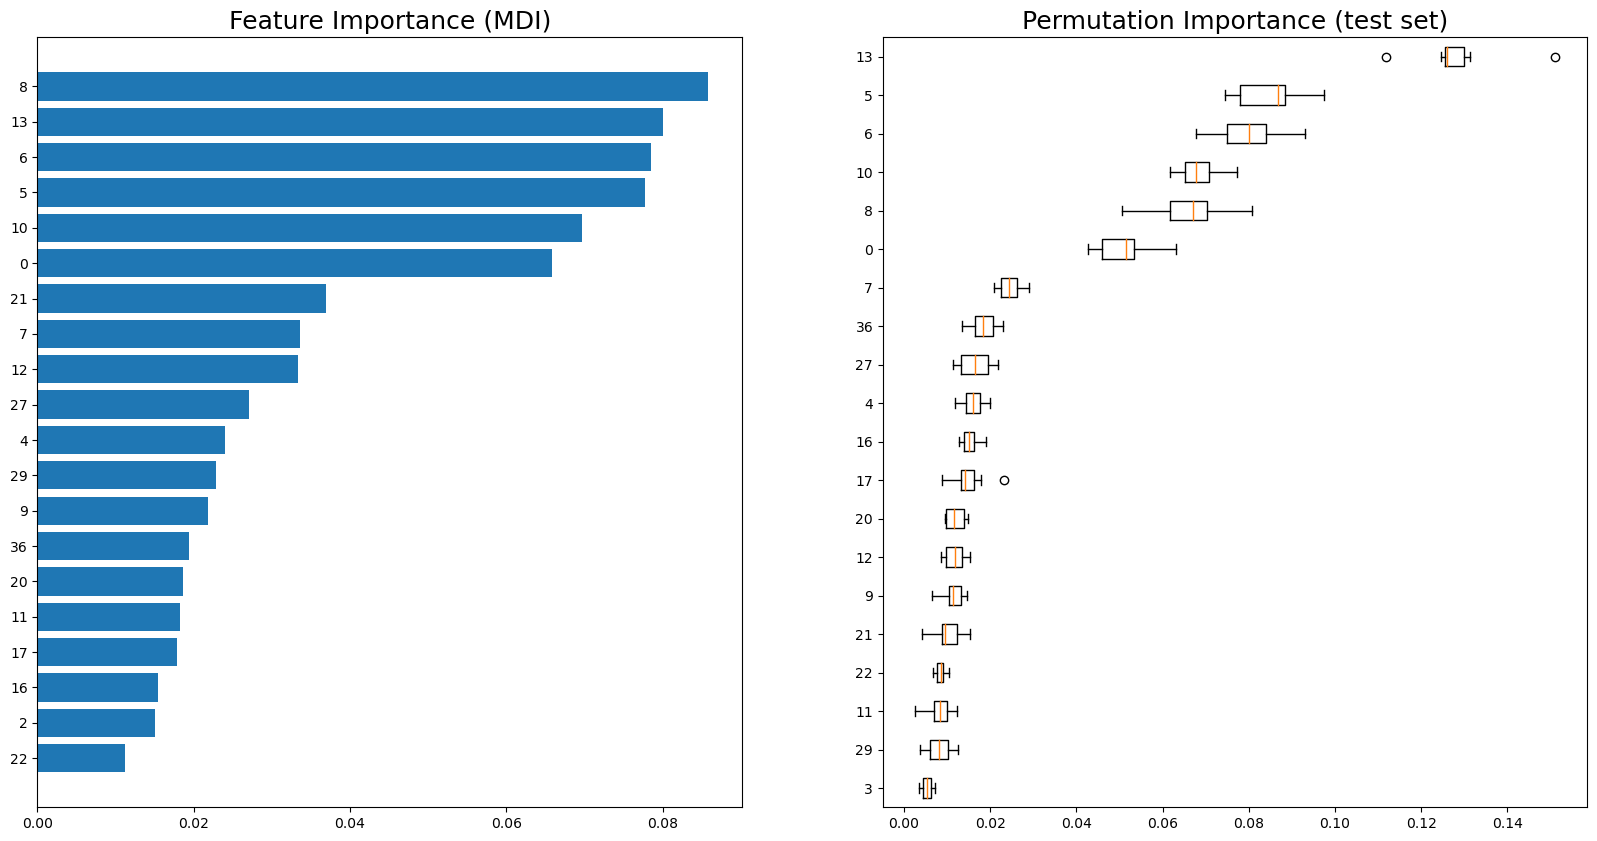

Data comparison is   --   BIAS: -0.00, SI: 0.71, Relative - RMSE: 0.38
 and Correlations (Pearson, Rscore): (0.68, 0.45)
 R score: 0.45 -- in TEST data


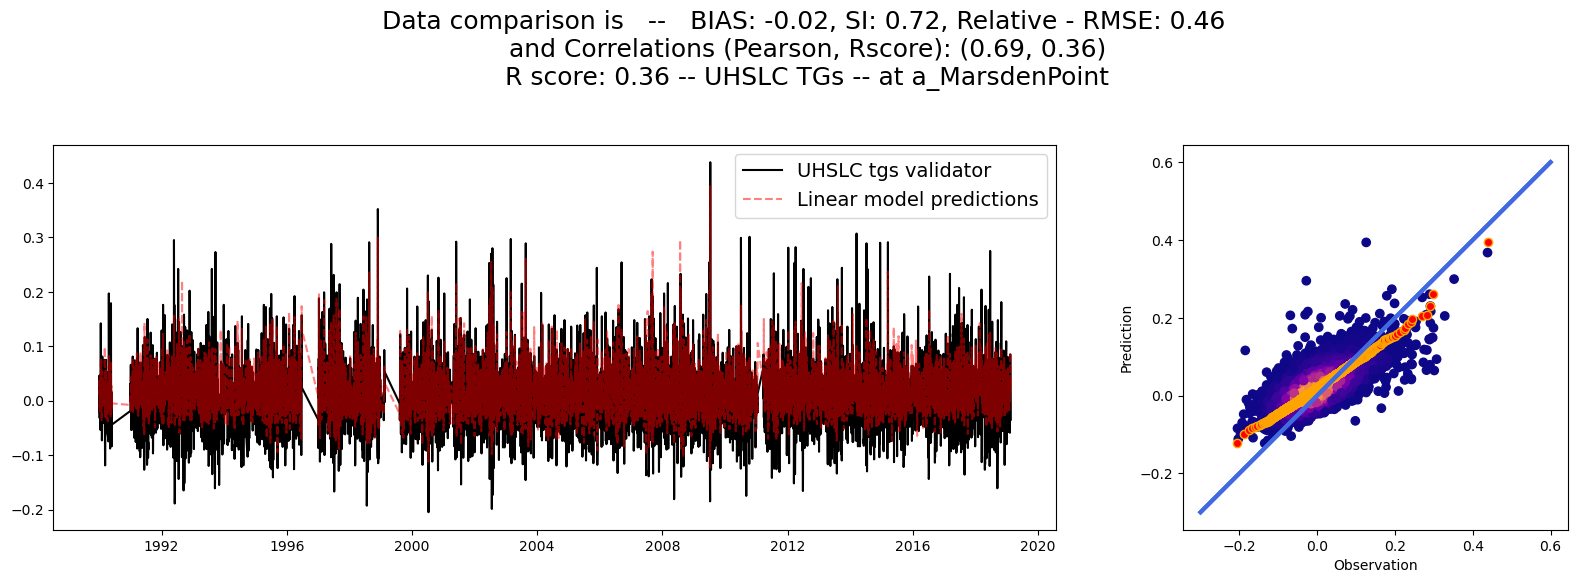


 90 PCs (0.8 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': [50], 'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_samples_split': array([0.02      , 0.03111111, 0.04222222, 0.05333333, 0.06444444,
       0.07555556, 0.08666667, 0.09777778, 0.10888889, 0.12      ]), 'learning_rate': [0.1], 'loss': ['ls']} grid parameters... 

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 best model fitted with {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 12, 'min_samples_split': 0.05333333333333333, 'n_estimators': 50} parameters!! 



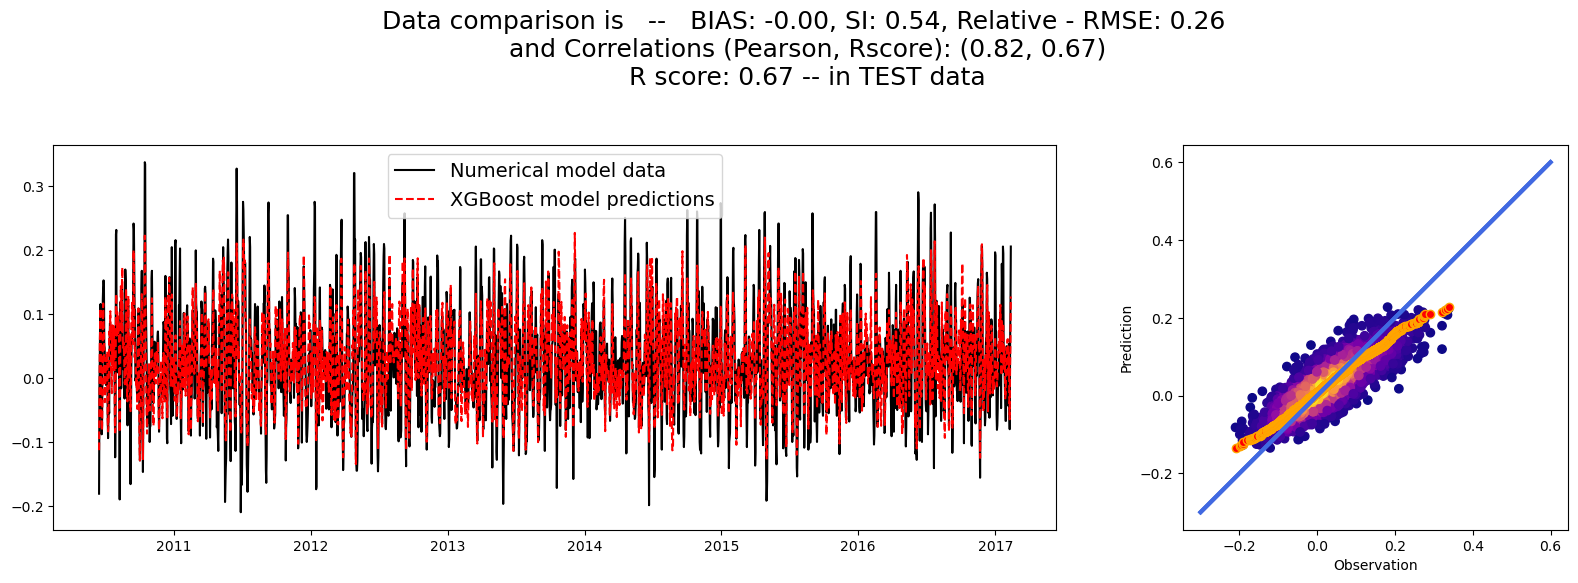

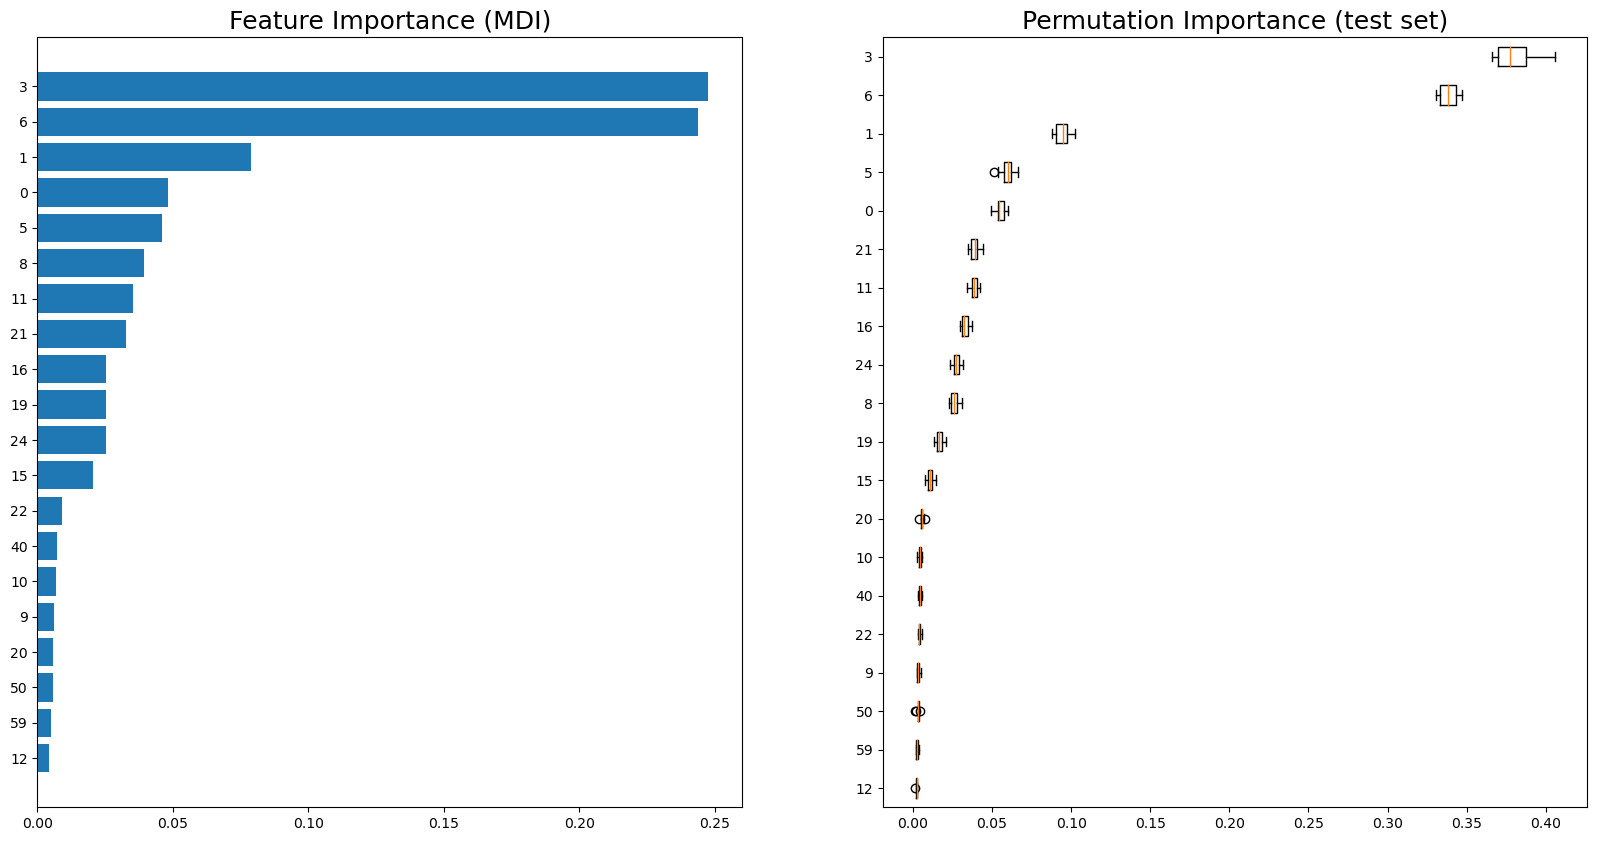

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 R score: 0.67 -- in TEST data


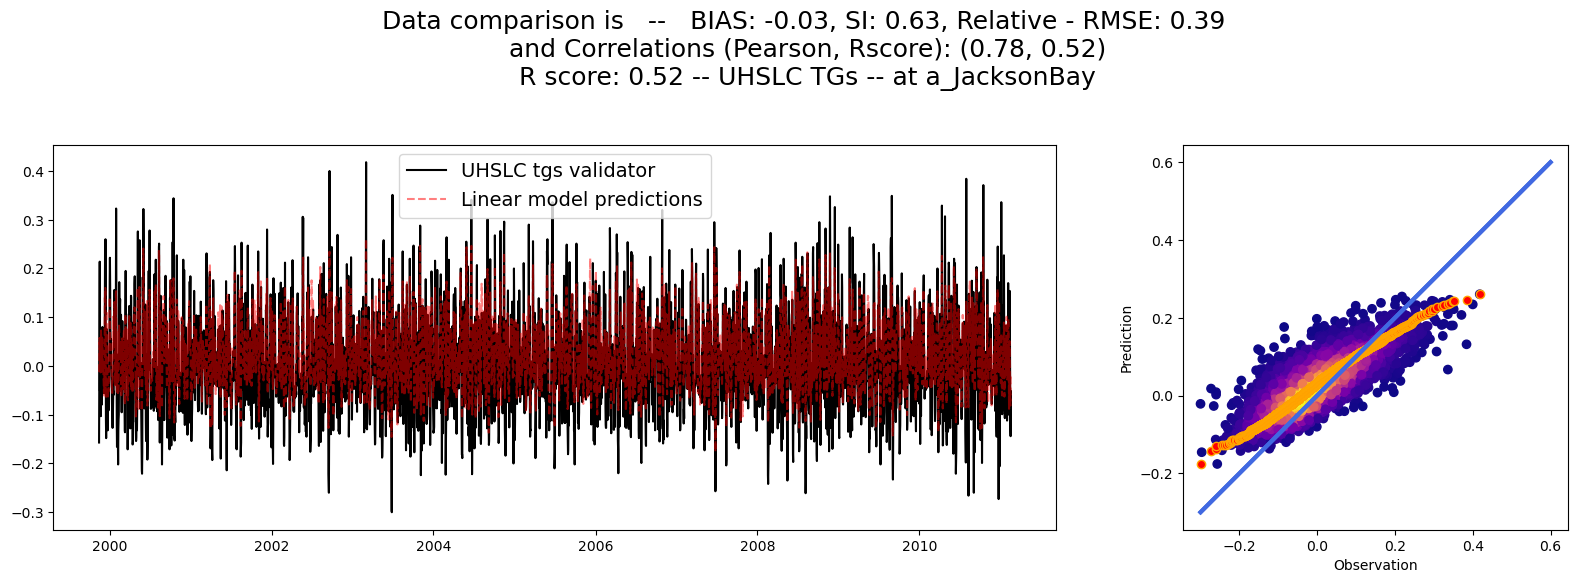


 90 PCs (0.8 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': [50], 'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_samples_split': array([0.02      , 0.03111111, 0.04222222, 0.05333333, 0.06444444,
       0.07555556, 0.08666667, 0.09777778, 0.10888889, 0.12      ]), 'learning_rate': [0.1], 'loss': ['ls']} grid parameters... 

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 best model fitted with {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 12, 'min_samples_split': 0.07555555555555556, 'n_estimators': 50} parameters!! 



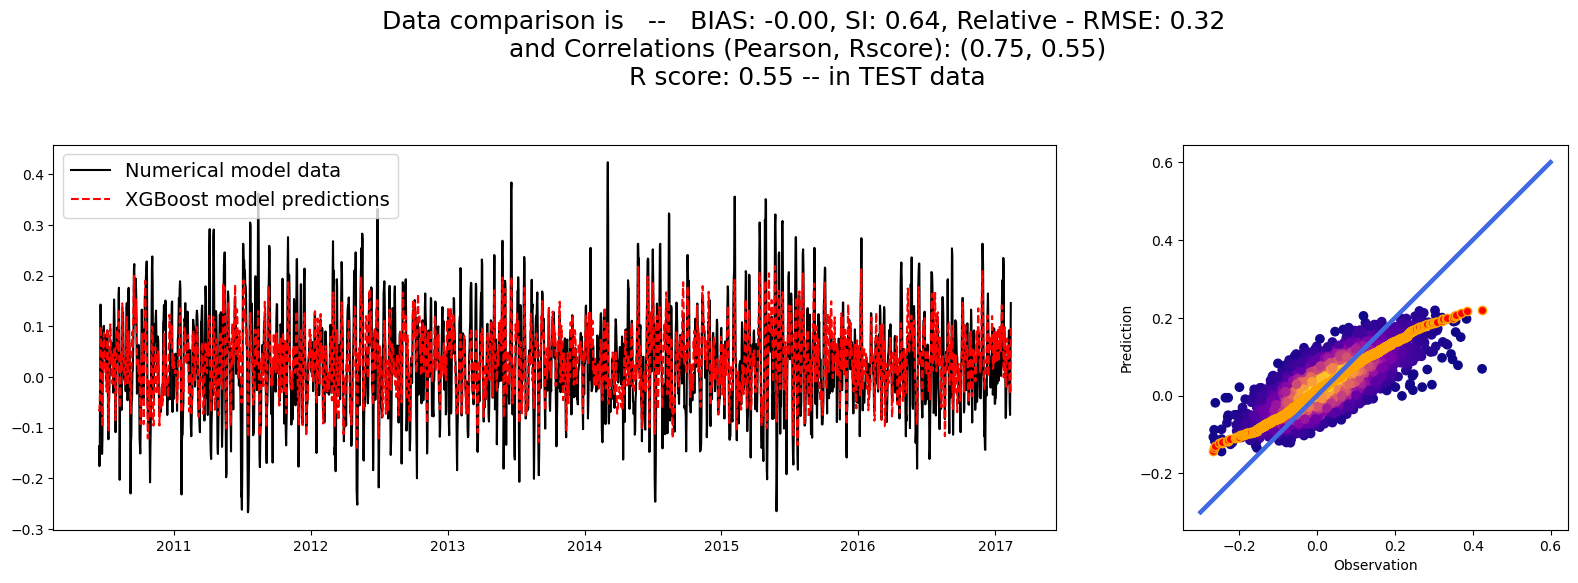

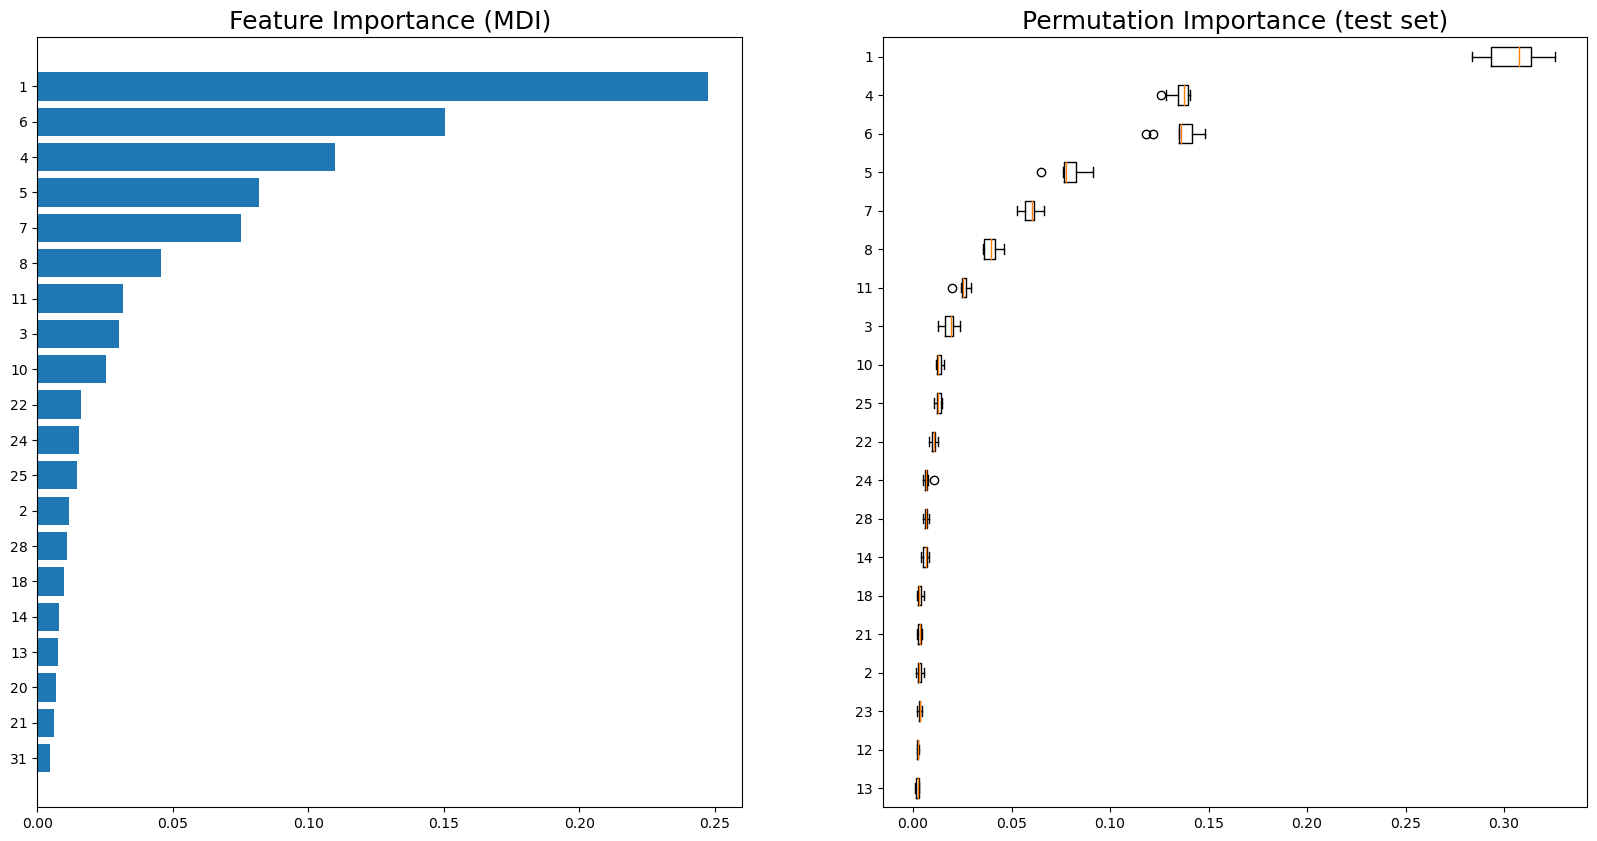

Data comparison is   --   BIAS: -0.00, SI: 0.64, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.75, 0.55)
 R score: 0.55 -- in TEST data


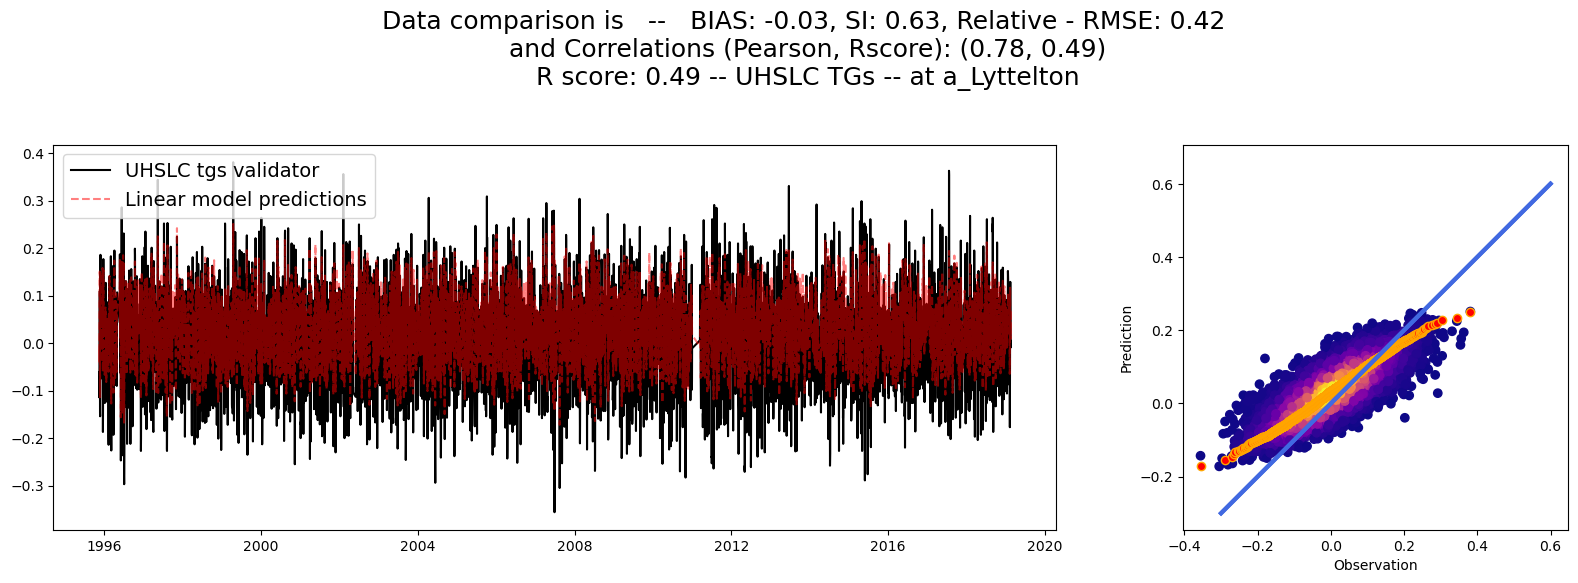


 90 PCs (0.8 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': [50], 'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_samples_split': array([0.02      , 0.03111111, 0.04222222, 0.05333333, 0.06444444,
       0.07555556, 0.08666667, 0.09777778, 0.10888889, 0.12      ]), 'learning_rate': [0.1], 'loss': ['ls']} grid parameters... 

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 best model fitted with {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 11, 'min_samples_split': 0.07555555555555556, 'n_estimators': 50} parameters!! 



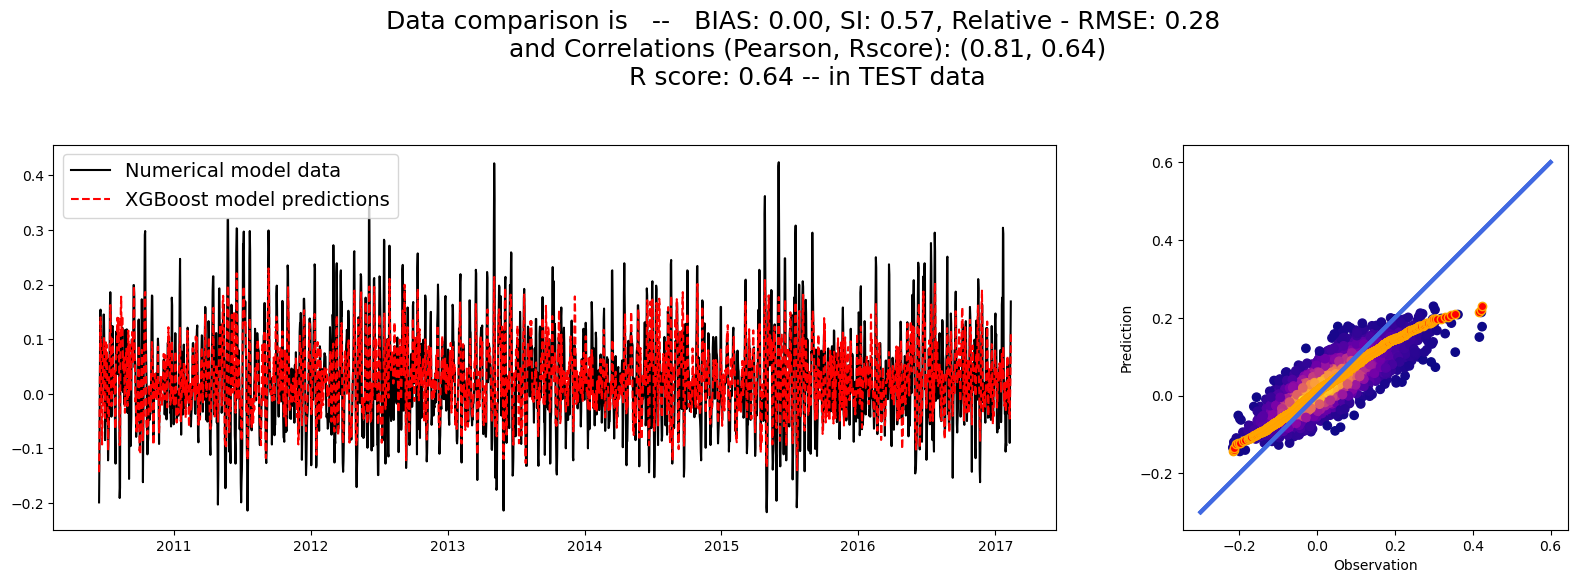

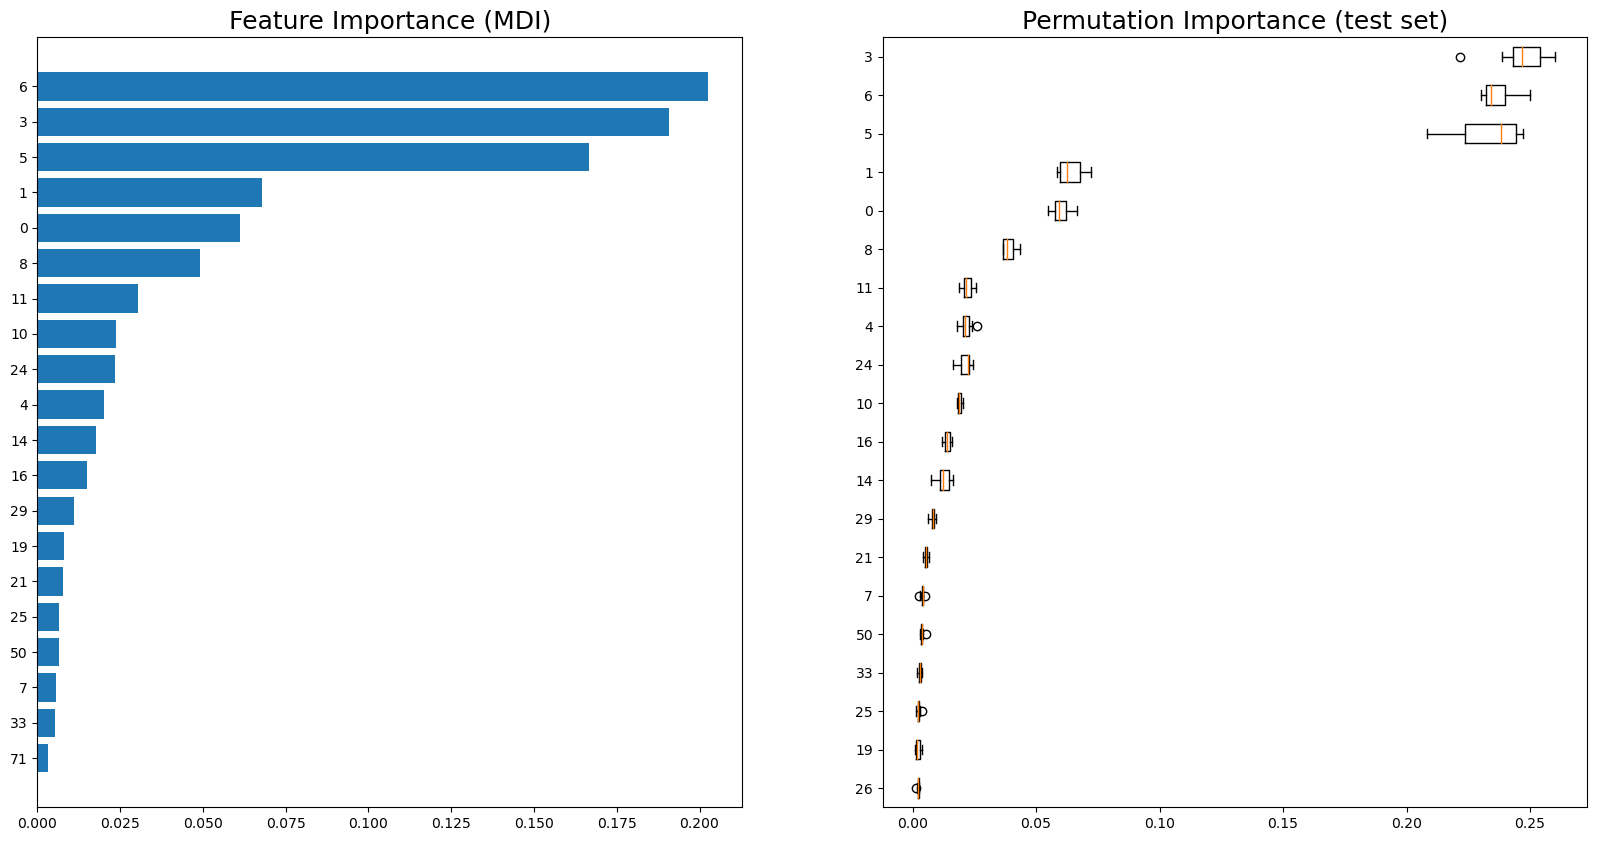

Data comparison is   --   BIAS: 0.00, SI: 0.57, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.81, 0.64)
 R score: 0.64 -- in TEST data


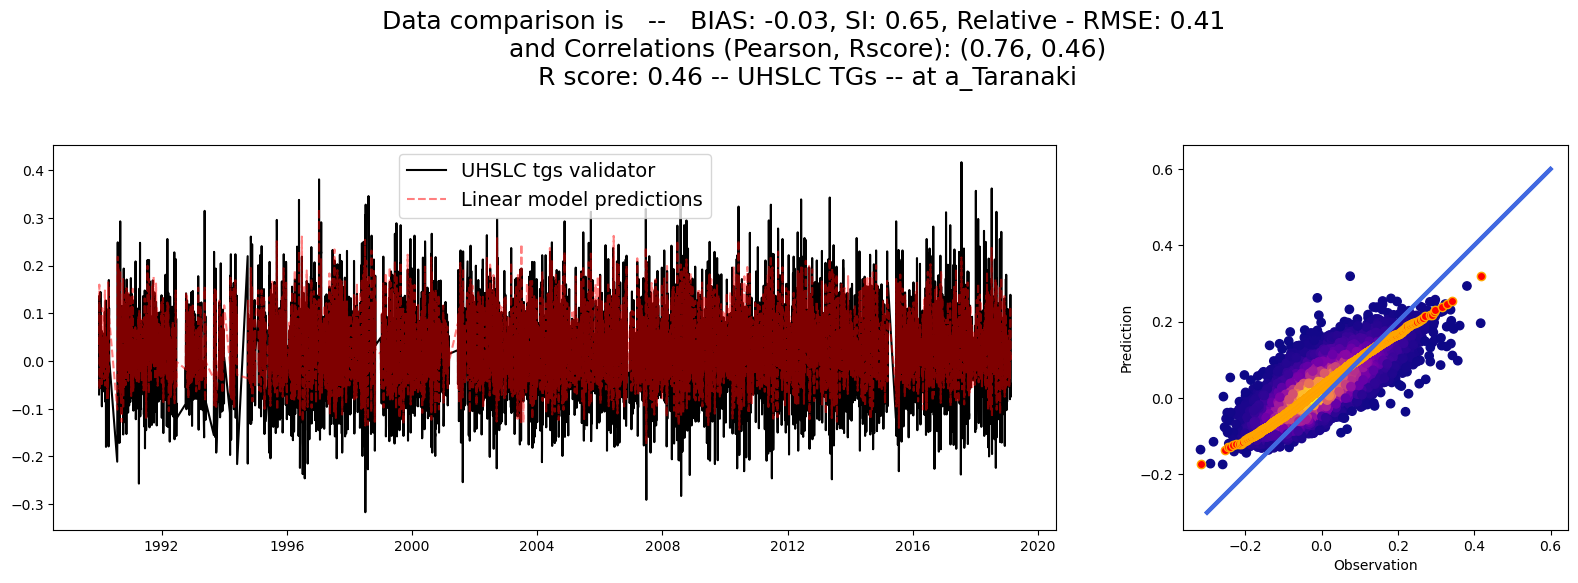


 90 PCs (0.8 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': [50], 'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_samples_split': array([0.02      , 0.03111111, 0.04222222, 0.05333333, 0.06444444,
       0.07555556, 0.08666667, 0.09777778, 0.10888889, 0.12      ]), 'learning_rate': [0.1], 'loss': ['ls']} grid parameters... 

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 best model fitted with {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 12, 'min_samples_split': 0.06444444444444444, 'n_estimators': 50} parameters!! 



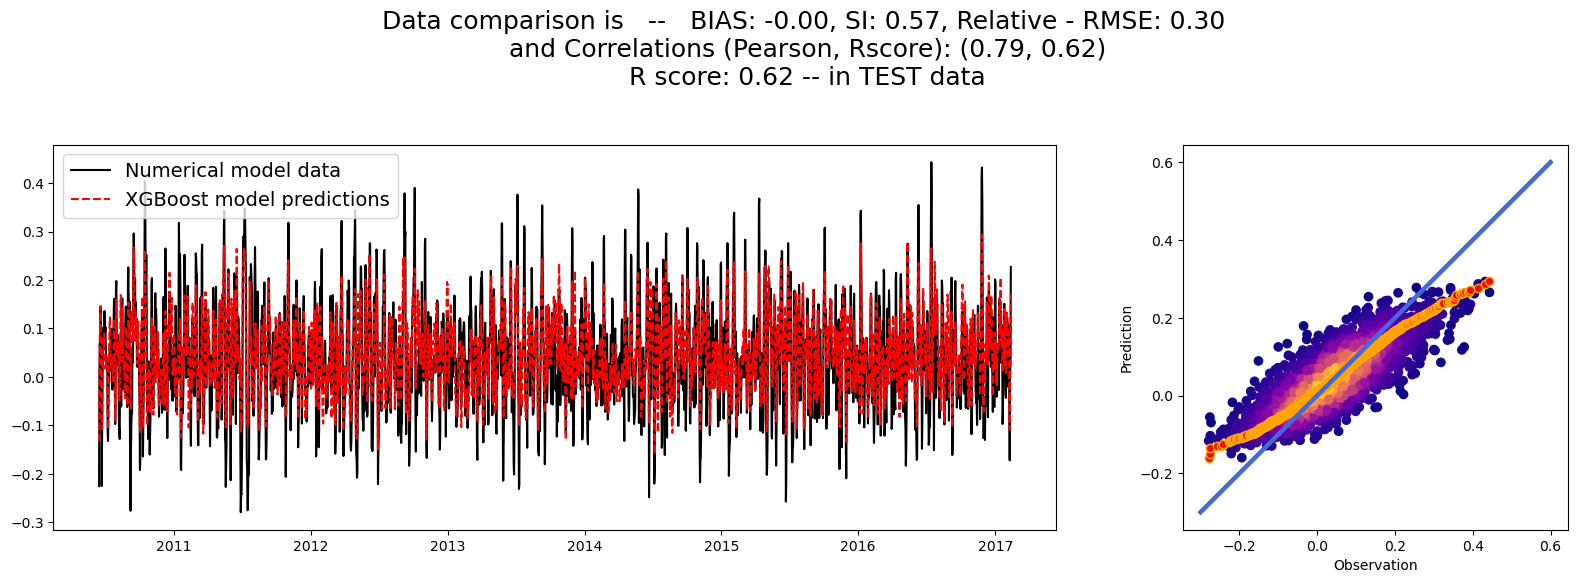

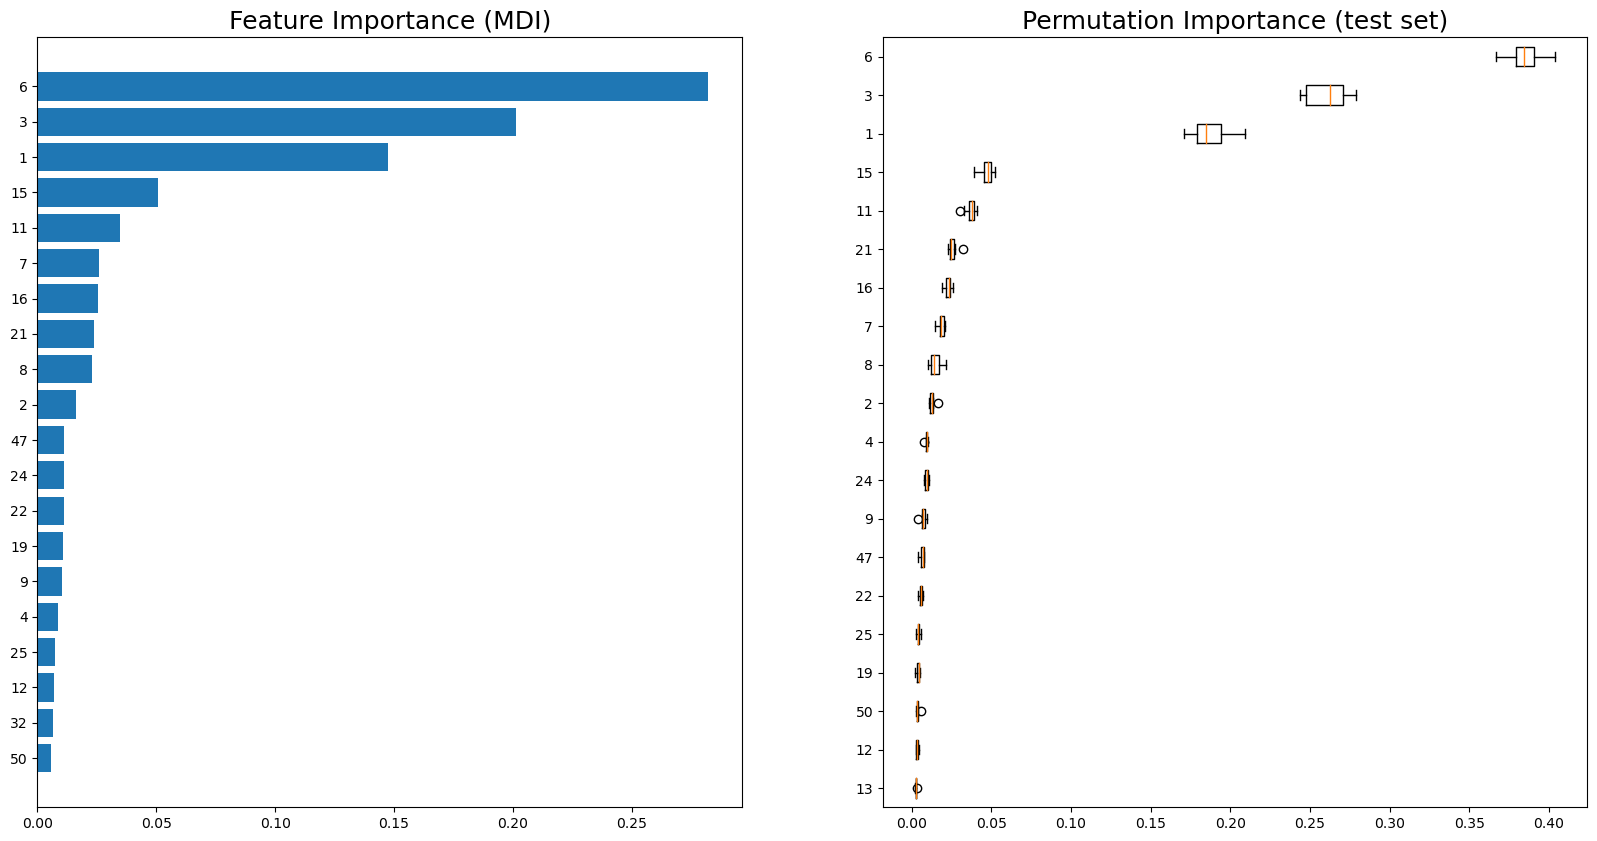

Data comparison is   --   BIAS: -0.00, SI: 0.57, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.79, 0.62)
 R score: 0.62 -- in TEST data


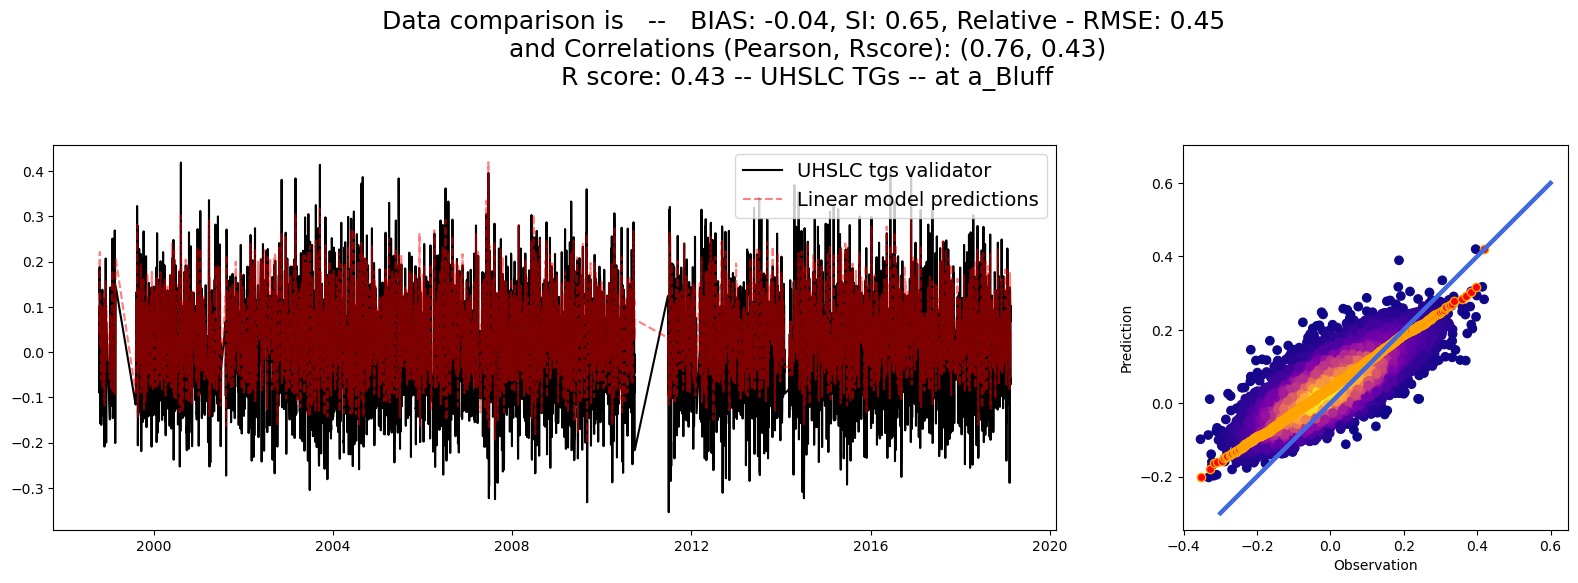


 90 PCs (0.8 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': [50], 'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_samples_split': array([0.02      , 0.03111111, 0.04222222, 0.05333333, 0.06444444,
       0.07555556, 0.08666667, 0.09777778, 0.10888889, 0.12      ]), 'learning_rate': [0.1], 'loss': ['ls']} grid parameters... 

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 best model fitted with {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 12, 'min_samples_split': 0.10888888888888888, 'n_estimators': 50} parameters!! 



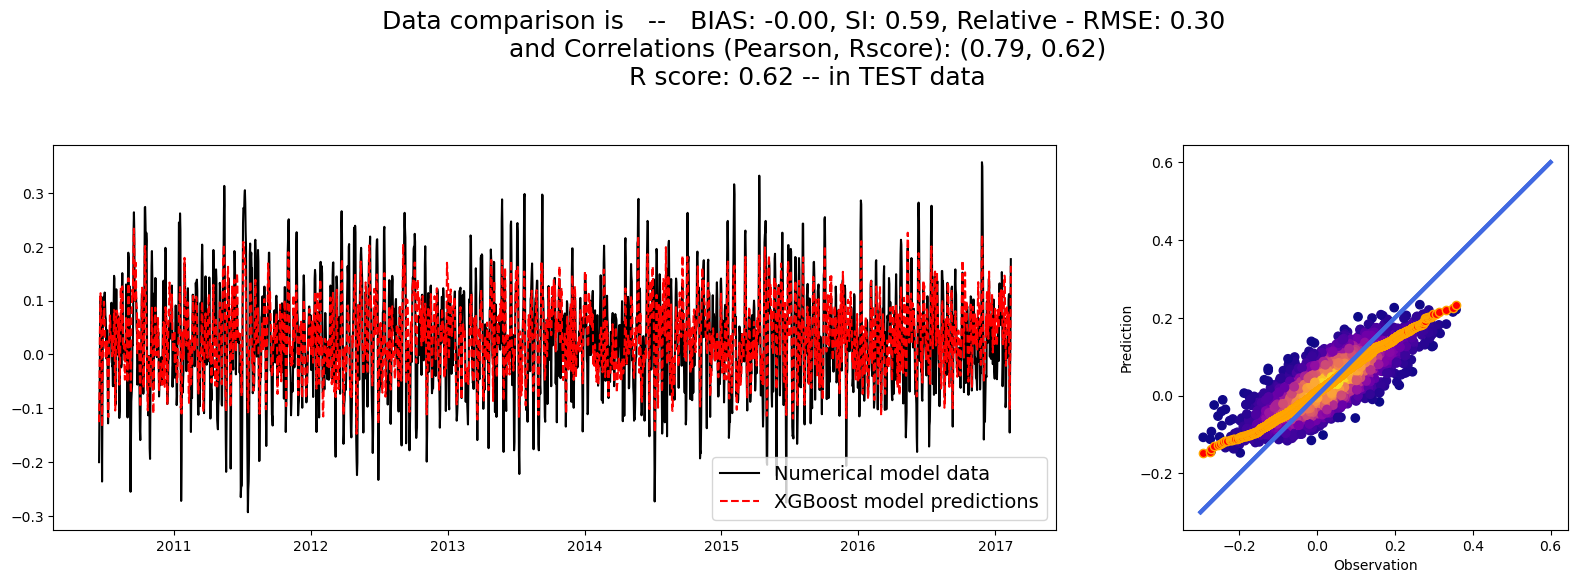

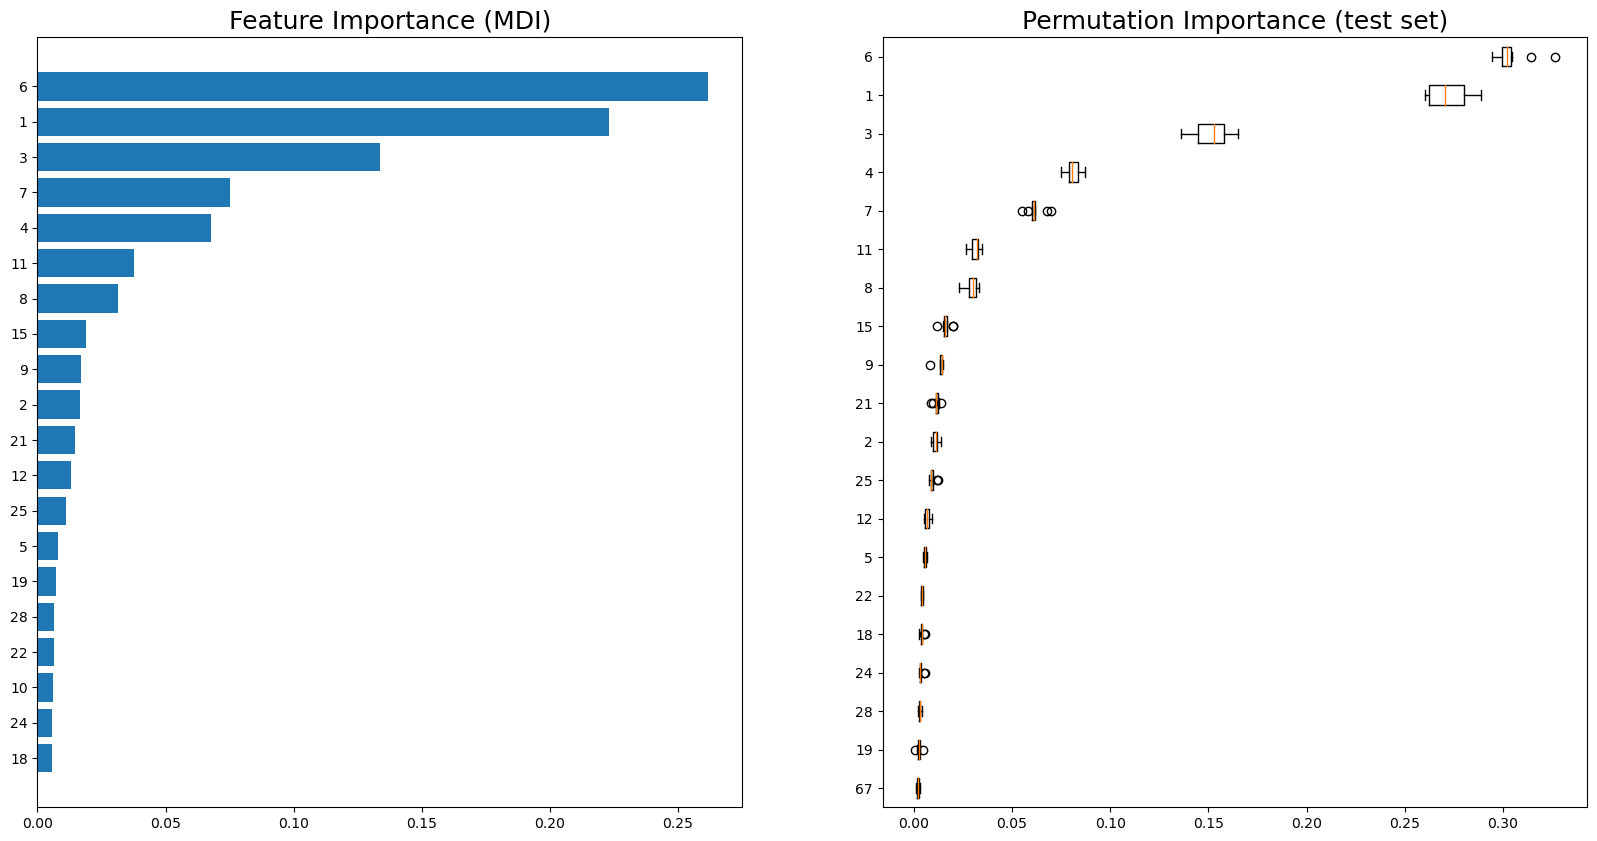

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.79, 0.62)
 R score: 0.62 -- in TEST data


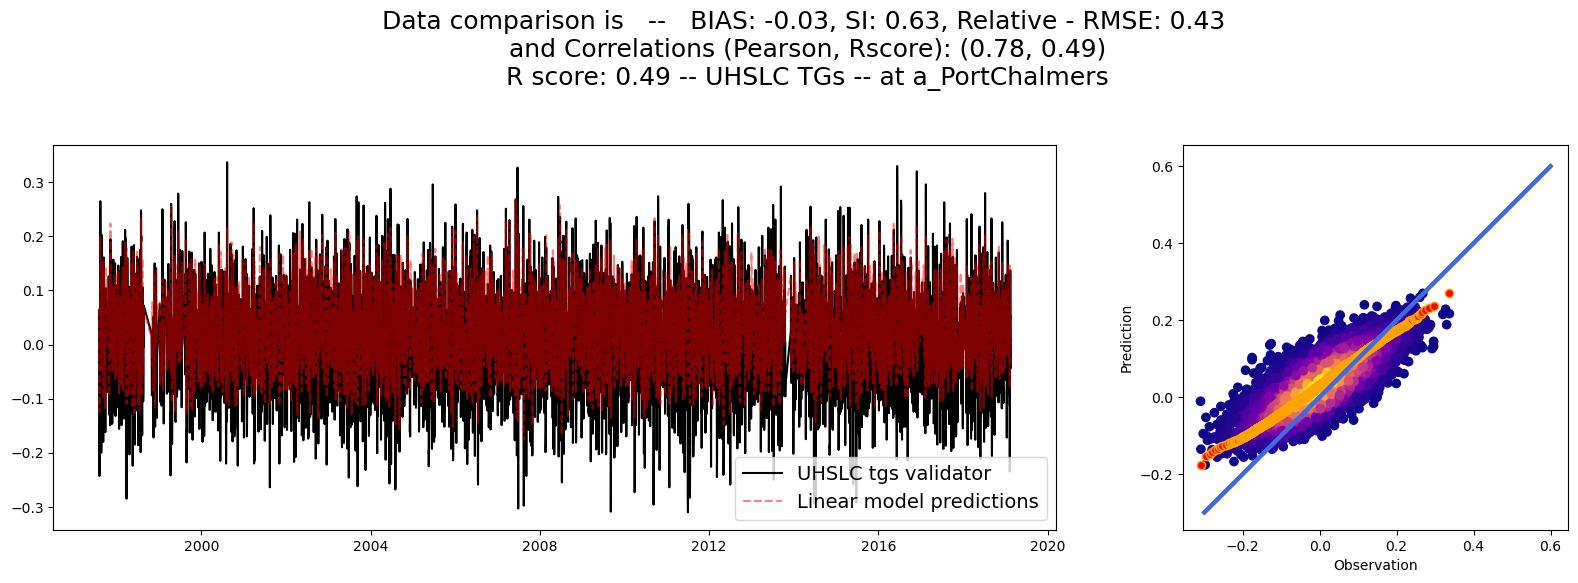


 90 PCs (0.8 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': [50], 'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_samples_split': array([0.02      , 0.03111111, 0.04222222, 0.05333333, 0.06444444,
       0.07555556, 0.08666667, 0.09777778, 0.10888889, 0.12      ]), 'learning_rate': [0.1], 'loss': ['ls']} grid parameters... 

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 best model fitted with {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 12, 'min_samples_split': 0.08666666666666666, 'n_estimators': 50} parameters!! 



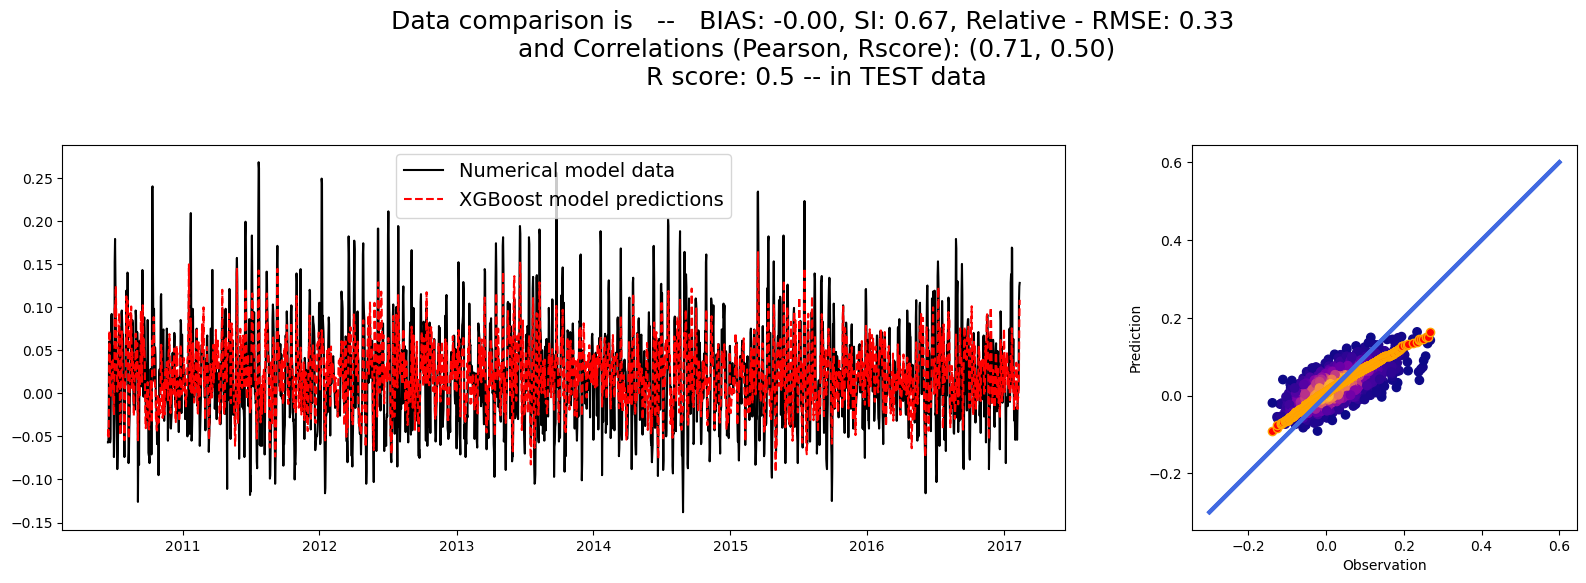

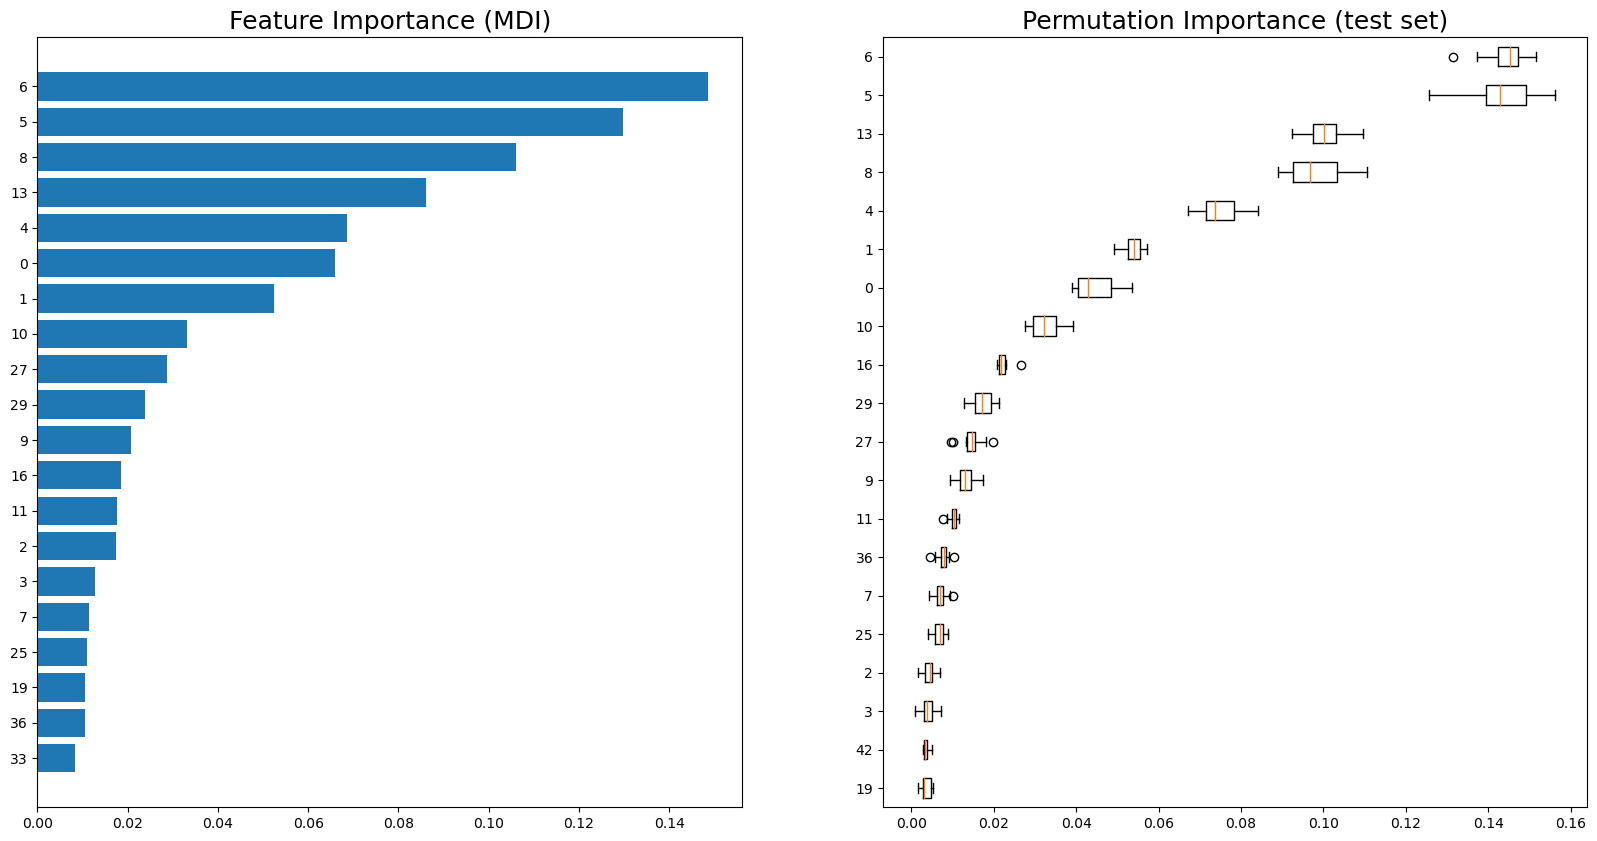

Data comparison is   --   BIAS: -0.00, SI: 0.67, Relative - RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.71, 0.50)
 R score: 0.5 -- in TEST data


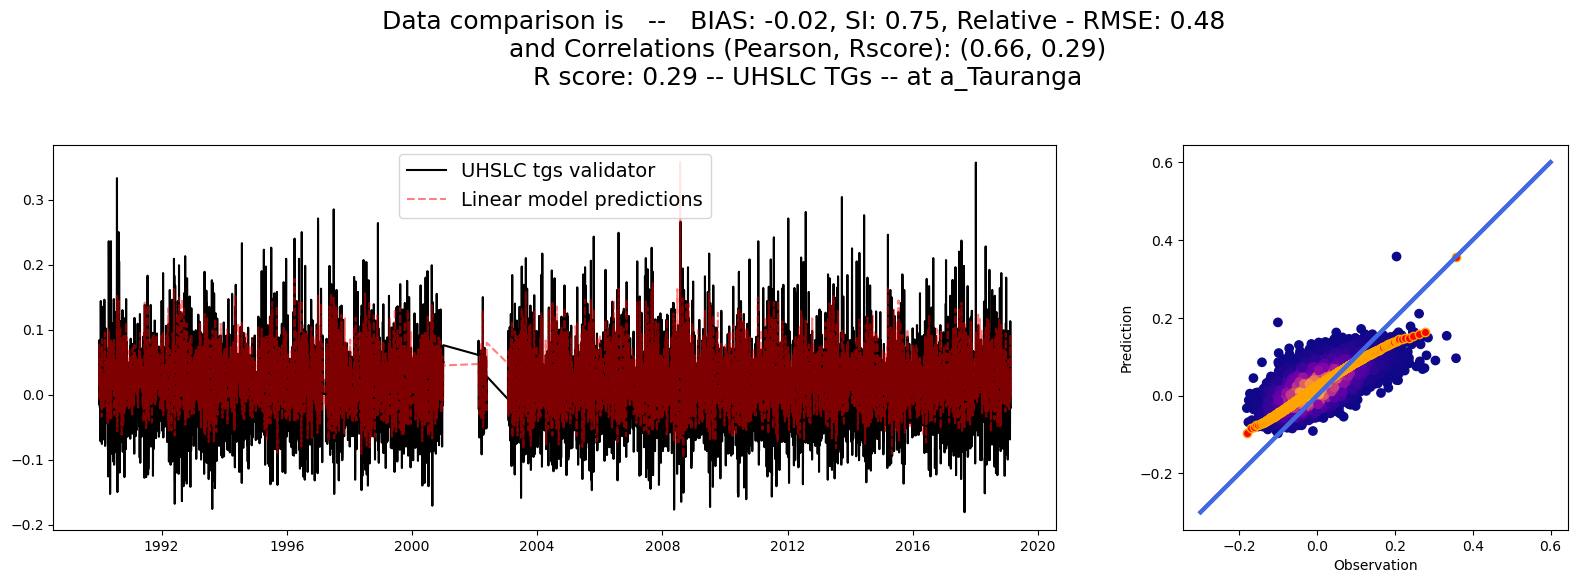


 90 PCs (0.8 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': [50], 'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_samples_split': array([0.02      , 0.03111111, 0.04222222, 0.05333333, 0.06444444,
       0.07555556, 0.08666667, 0.09777778, 0.10888889, 0.12      ]), 'learning_rate': [0.1], 'loss': ['ls']} grid parameters... 

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 best model fitted with {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 11, 'min_samples_split': 0.05333333333333333, 'n_estimators': 50} parameters!! 



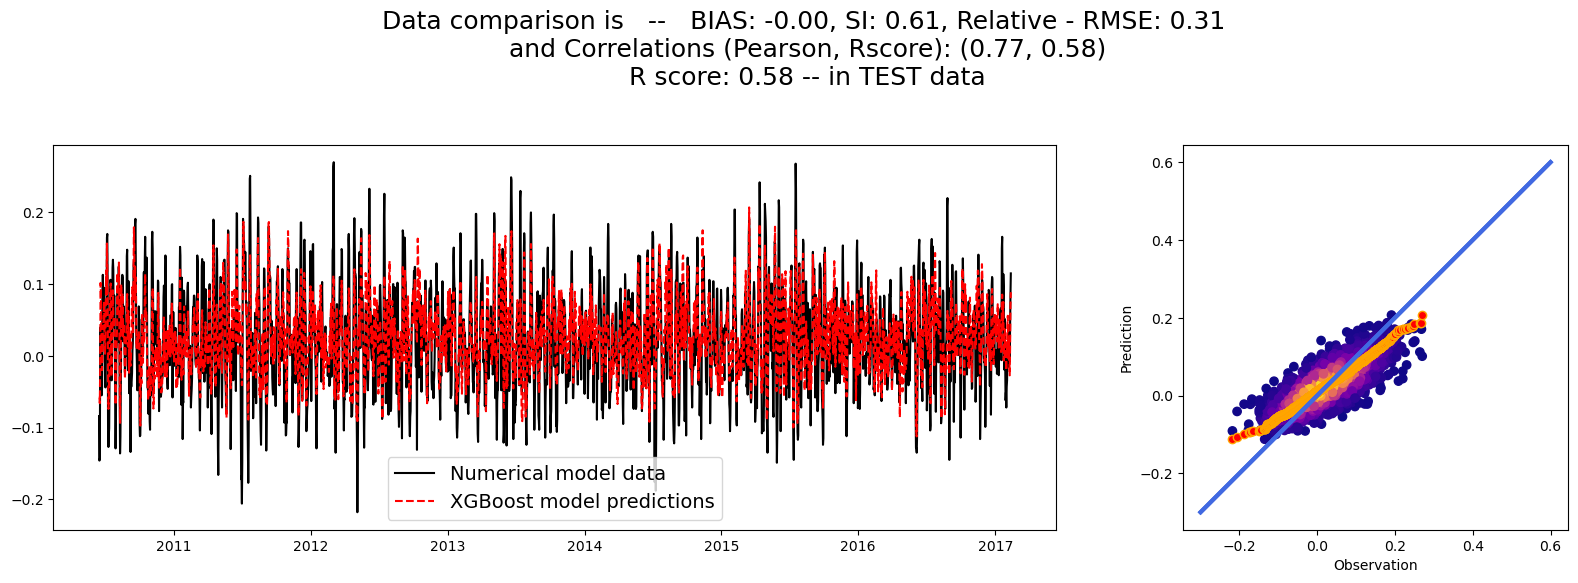

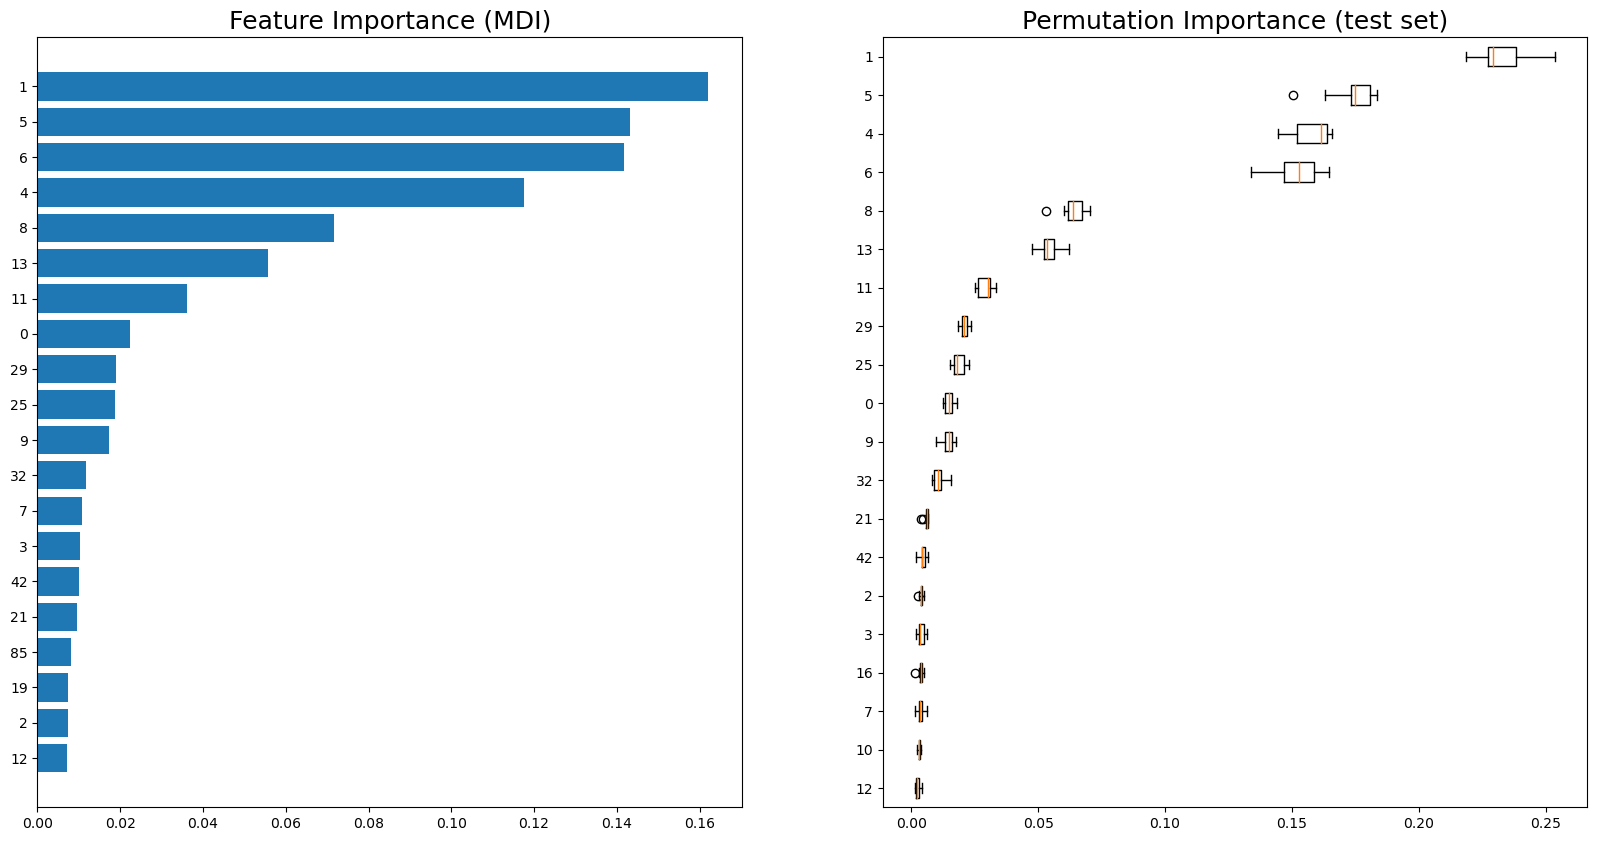

Data comparison is   --   BIAS: -0.00, SI: 0.61, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.77, 0.58)
 R score: 0.58 -- in TEST data


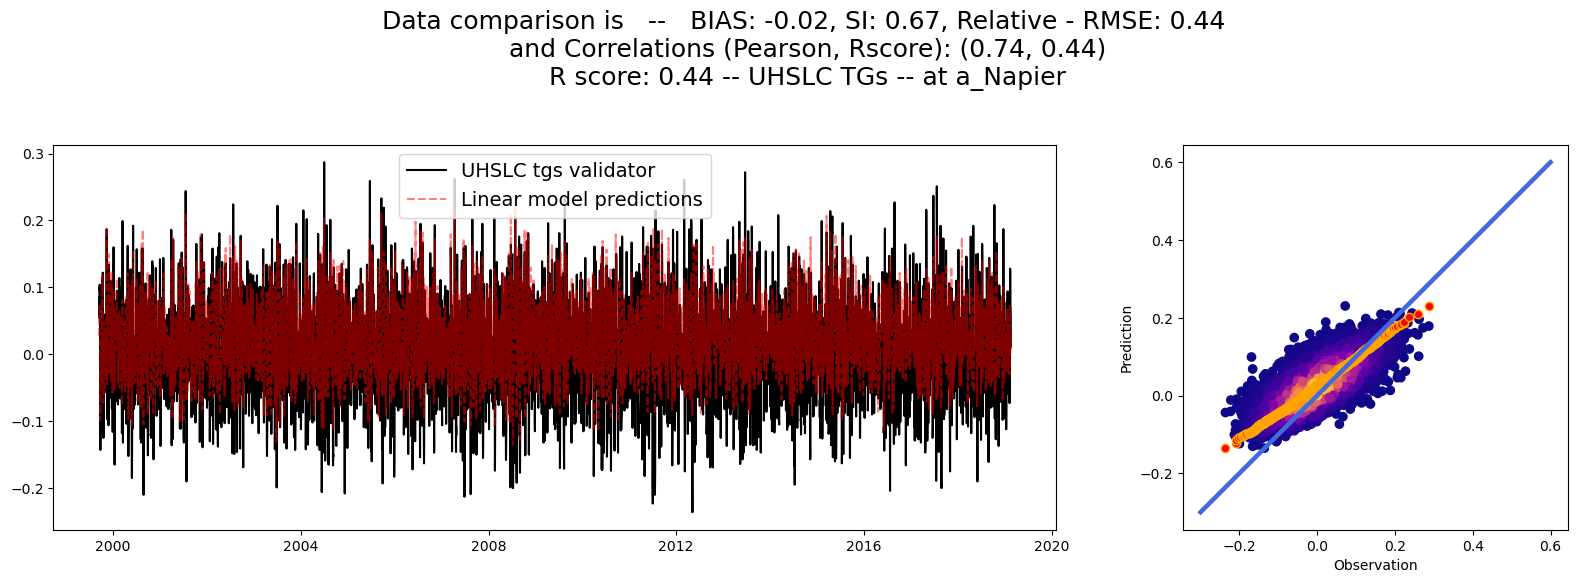


 90 PCs (0.8 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': [50], 'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_samples_split': array([0.02      , 0.03111111, 0.04222222, 0.05333333, 0.06444444,
       0.07555556, 0.08666667, 0.09777778, 0.10888889, 0.12      ]), 'learning_rate': [0.1], 'loss': ['ls']} grid parameters... 

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 best model fitted with {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 11, 'min_samples_split': 0.07555555555555556, 'n_estimators': 50} parameters!! 



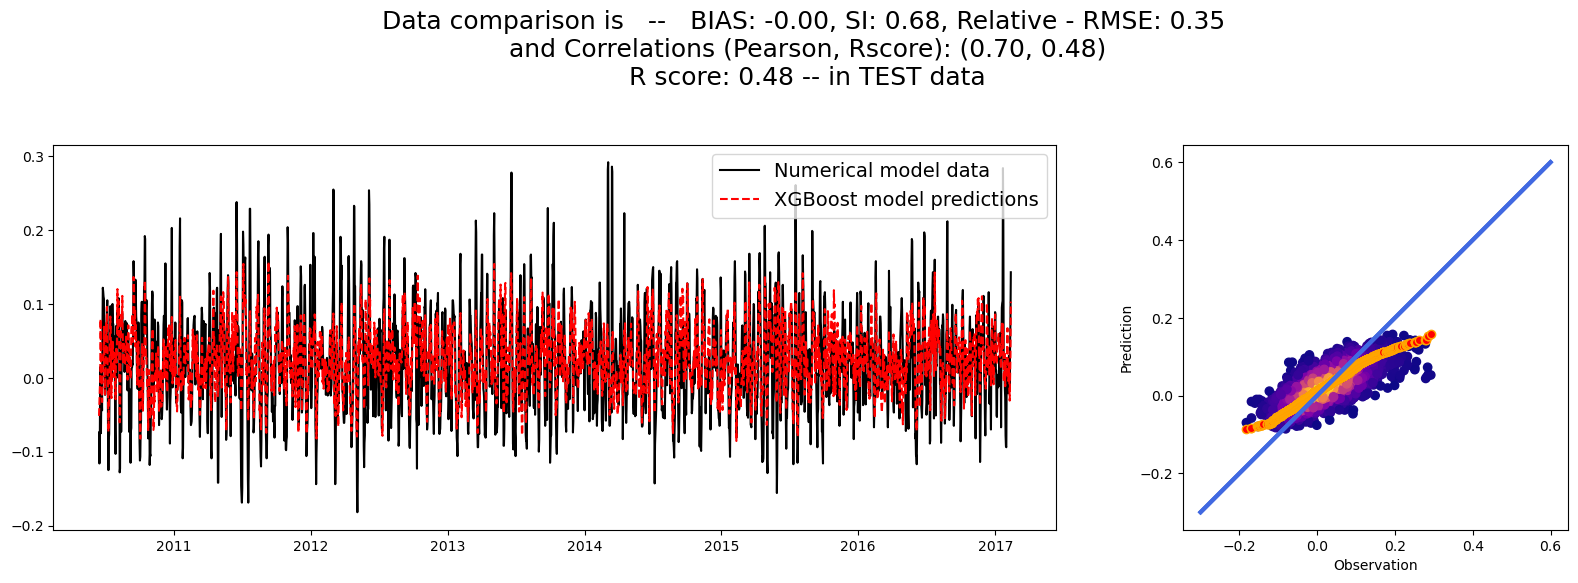

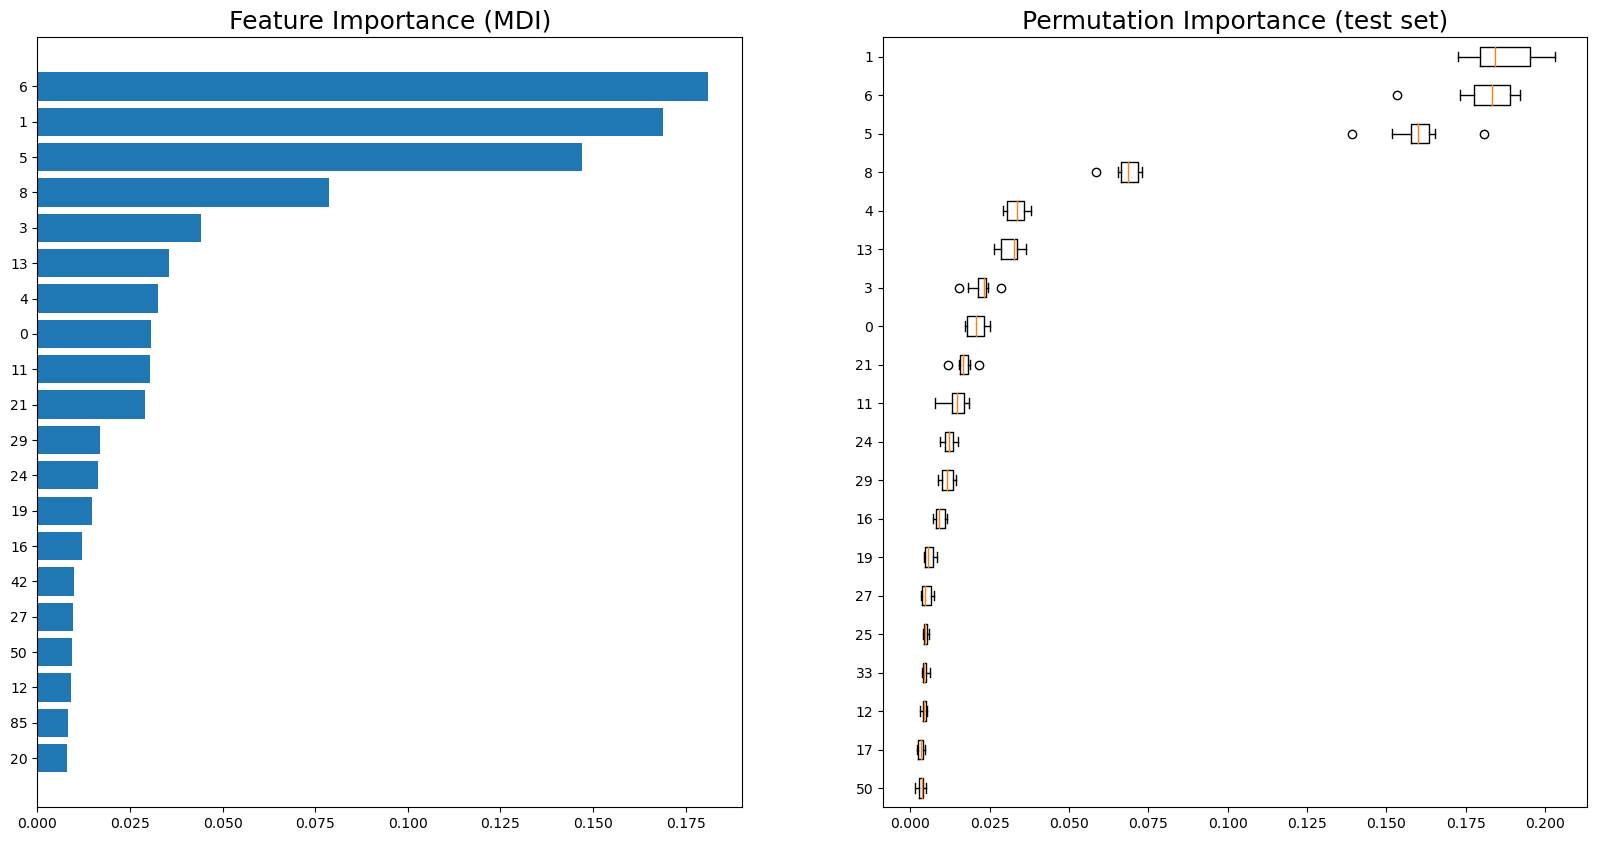

Data comparison is   --   BIAS: -0.00, SI: 0.68, Relative - RMSE: 0.35
 and Correlations (Pearson, Rscore): (0.70, 0.48)
 R score: 0.48 -- in TEST data


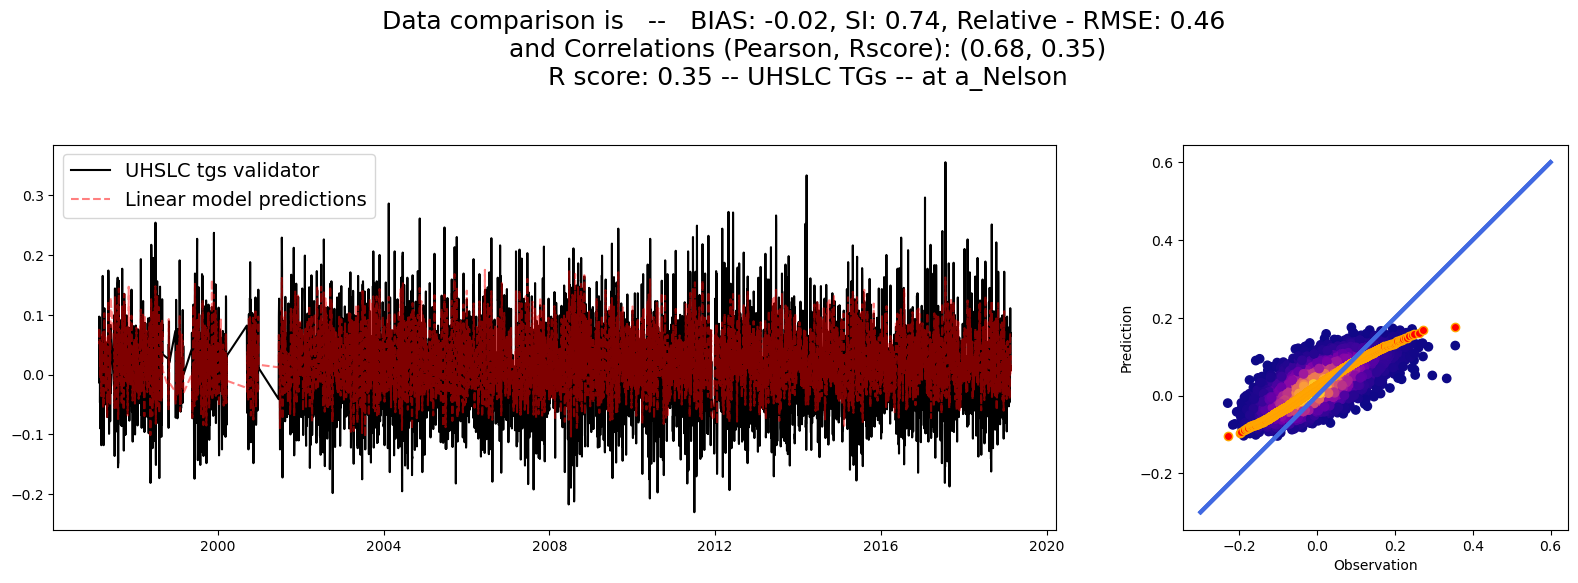

In [15]:
# validate model with tgs
stats = []
models = []
# select sites and append closest to UHSLC tgs
clos_to_uhslc = [689, 328, 393, 1327, 393, 480, 999, 116, 224, 1124, 949, 708]
for istat,stat in enumerate(clos_to_uhslc):
    ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
        .load().resample(time='1D').max()
    stats_stat, model, pcs_to_use = XGBoost_Regression(
        pcs_cfsr, ss_moana, # pcs and ss data
        xgboost_parameters=None, # will perform CV
        xgboost_gscv_parameters = {
            'n_estimators': [50],
            'max_depth': np.arange(5,15,1),
            'min_samples_split': np.linspace(0.02,0.12,10),
            'learning_rate': [0.1],
            'loss': ['ls'] # more could be added
        },
        validator=(
            True,load_cfsr_moana_uhslc.validator.isel(name=istat),'ss'
        ), 
        plot_results=True, train_size=0.7, 
        percentage_PCs=0.8, verbose=True
    )
    stats.append(stats_stat)
    models.append(model)

### XGBoost regression - Ana's paper

In the two following cells, we try to replicate the same analysis that we made with the linear and KNN regression, but this time with the XGBoost regressor...


 loading and plotting the private tidal guages... 


 333 PCs (0.94 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': [40], 'max_depth': array([7, 9]), 'min_samples_split': array([0.01  , 0.1075, 0.205 , 0.3025, 0.4   ]), 'learning_rate': [0.1], 'loss': ['ls']} grid parameters... 

Fitting 2 folds for each of 10 candidates, totalling 20 fits

 best model fitted with {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 7, 'min_samples_split': 0.1075, 'n_estimators': 40} parameters!! 



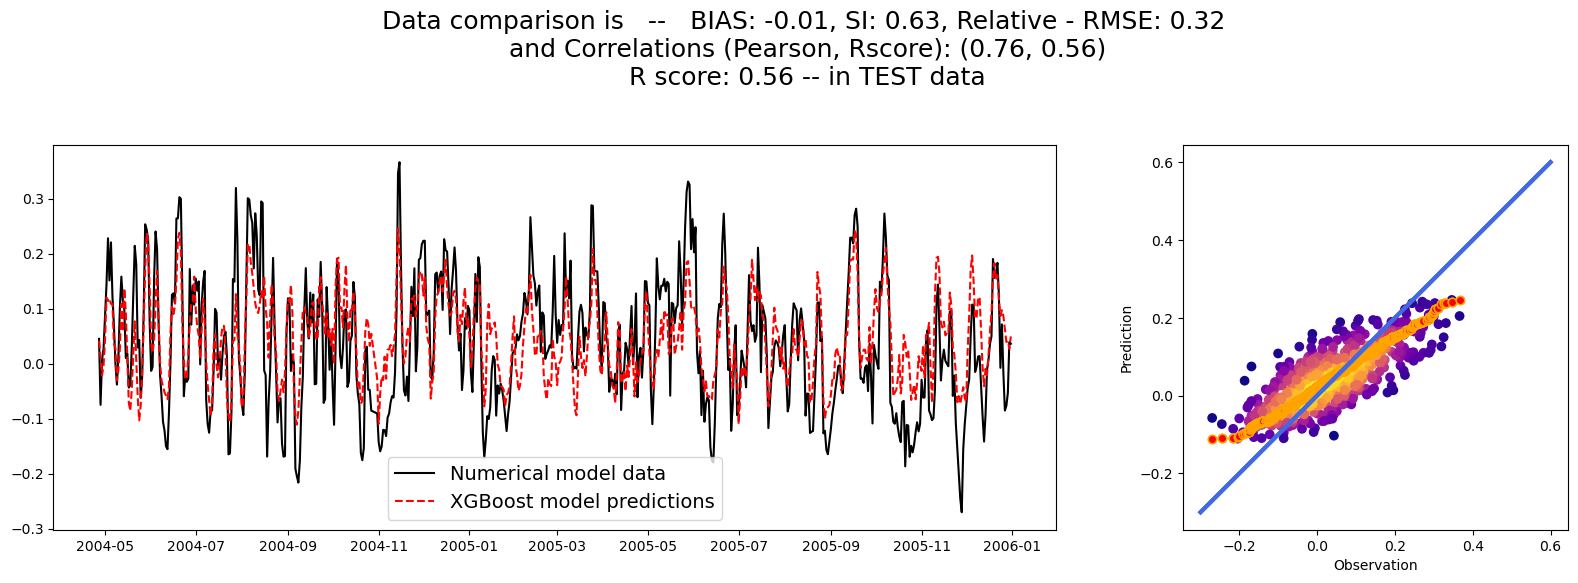

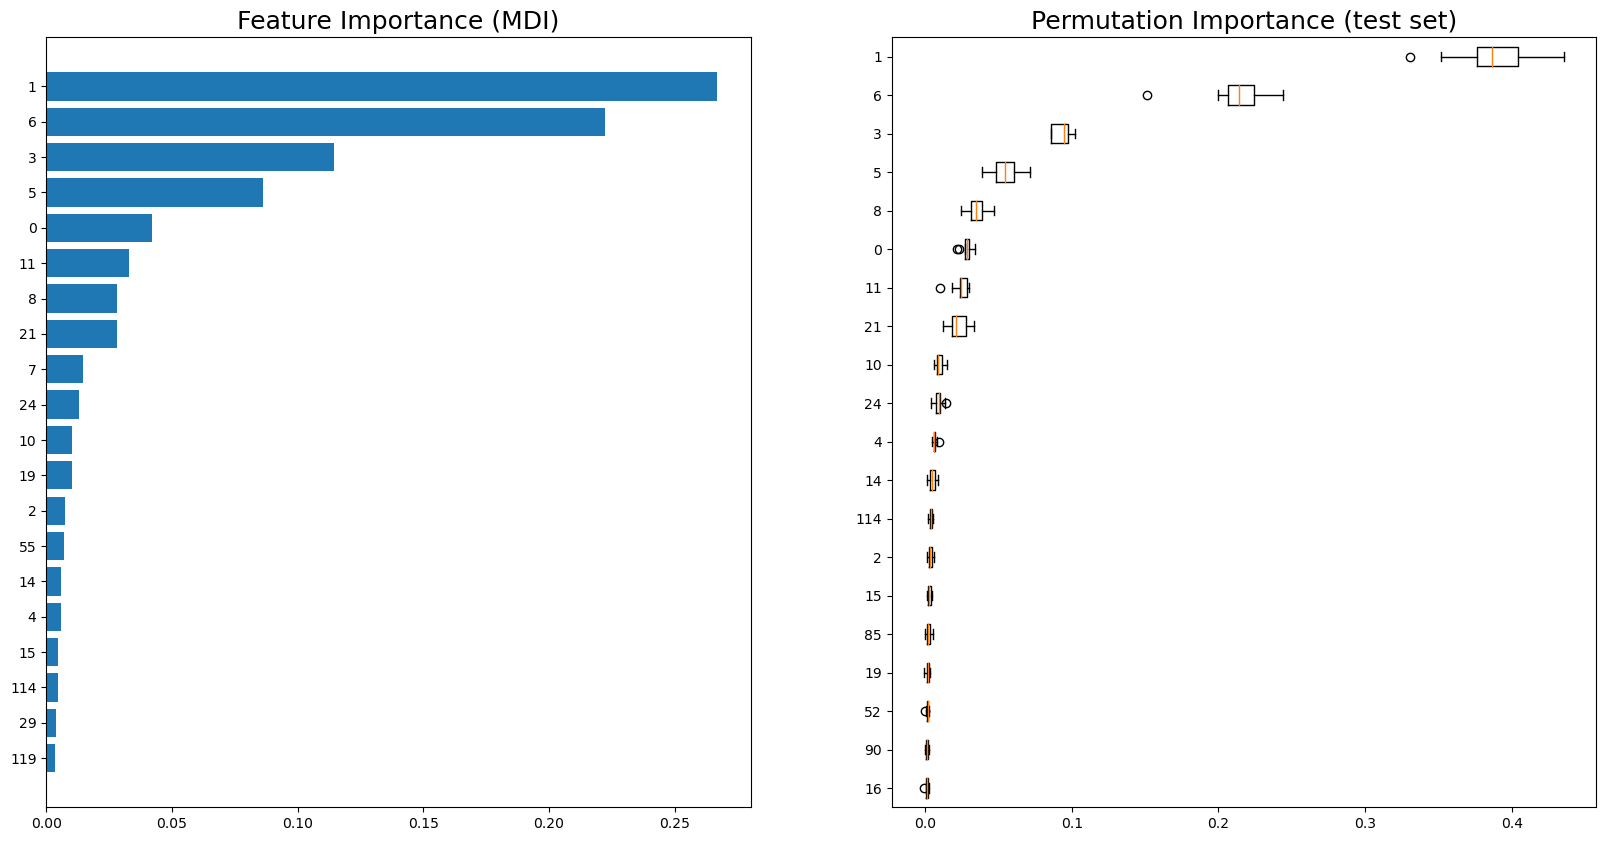

Data comparison is   --   BIAS: -0.01, SI: 0.63, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.76, 0.56)
 R score: 0.56 -- in TEST data


 -- METRICS -- 

 {'bias': -0.00885766759445529, 'si': 0.6273676899942839, 'rmse': 0.07697954681160739, 'rel_rmse': 0.32267588974581435, 'pearson': 0.7621879228373294, 'rscore': 0.5616776822571815, 'ext_rmse': 0.10924264078968221, 'ext_pearson': 0.45188133211395437} 

 obtained with GradientBoostingRegressor(max_depth=7, min_samples_split=0.1075,
                          n_estimators=40) !!


In [9]:
# xgboost regression in kapiti island
ss_kapiti = load_private_tgs().sel(name='Kapiti_Is').resample(time='1D').max()
stats_kapiti, kapiti_model, pcs_to_use_kapiti = XGBoost_Regression(
    pcs_cfsr, ss_kapiti, plot_results=True, verbose=True,
    percentage_PCs=0.94, train_size=0.8, xgboost_parameters=None,
    xgboost_gscv_parameters = {
        'n_estimators': [40],
        'max_depth': np.arange(7,11,2),
        'min_samples_split': np.linspace(0.01,0.4,5),
        'learning_rate': [0.1],
        'loss': ['ls'] # more could be added
    }
)
print(f'\n\n -- METRICS -- \n\n {stats_kapiti} \n\n obtained with {kapiti_model} !!')

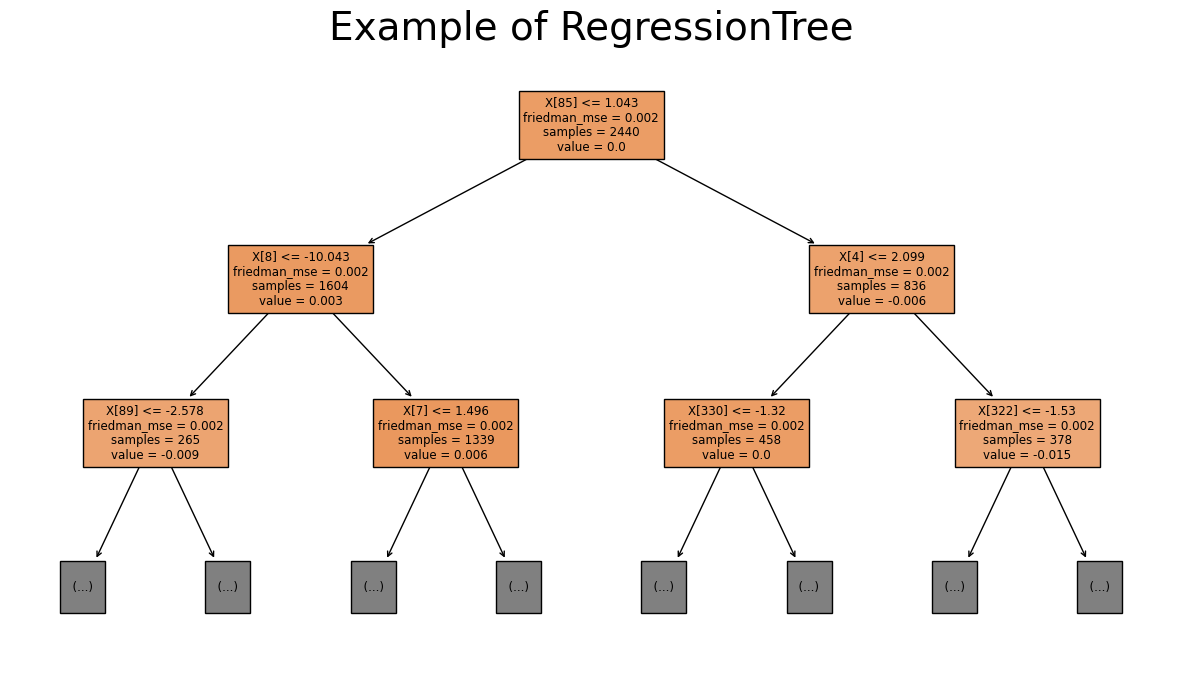

In [10]:
fig, ax = plt.subplots(figsize=(15,8))
plot_tree(kapiti_model.estimators_[-1][0],
          max_depth=2,filled=True,ax=ax)
ax.set_title('Example of RegressionTree',fontsize=28)
plt.show()


 loading and plotting the private tidal guages... 


 90 PCs (0.8 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': [40], 'max_depth': array([ 3,  5,  7,  9, 11]), 'min_samples_split': array([0.01   , 0.02125, 0.0325 , 0.04375, 0.055  , 0.06625, 0.0775 ,
       0.08875, 0.1    ]), 'learning_rate': [0.1], 'loss': ['ls']} grid parameters... 

Fitting 2 folds for each of 45 candidates, totalling 90 fits

 best model fitted with {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 7, 'min_samples_split': 0.08875000000000001, 'n_estimators': 40} parameters!! 



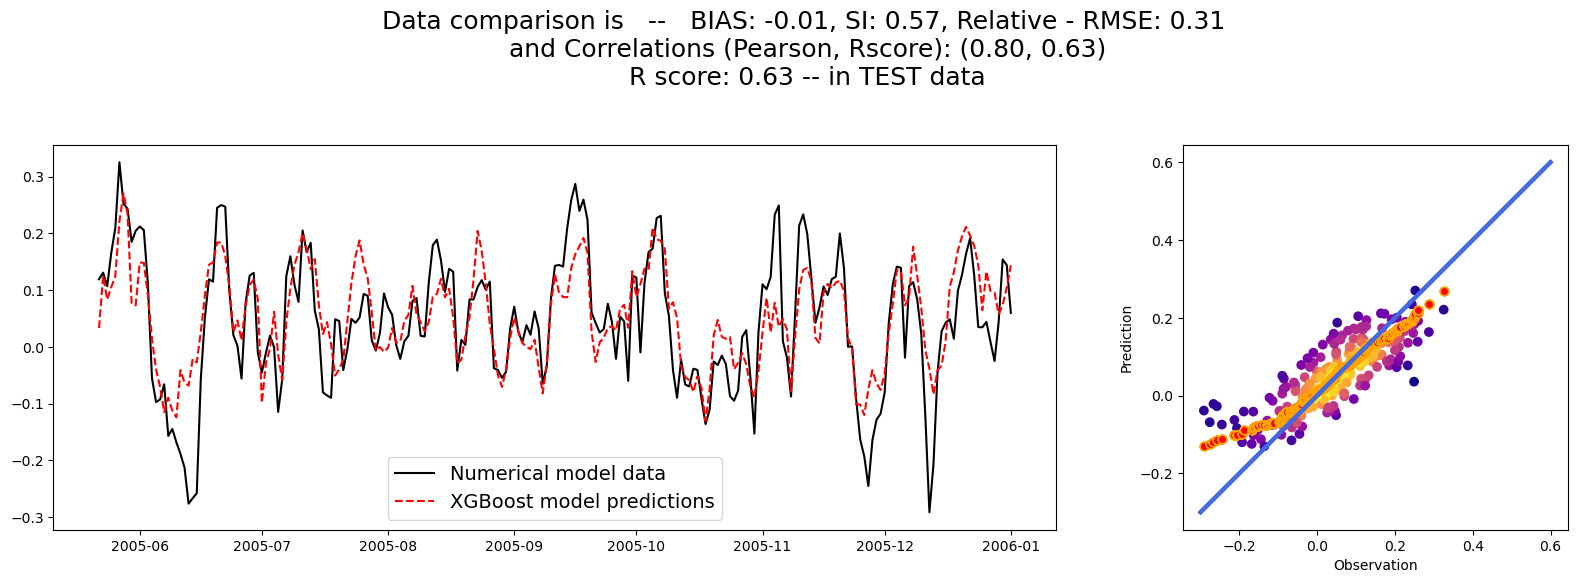

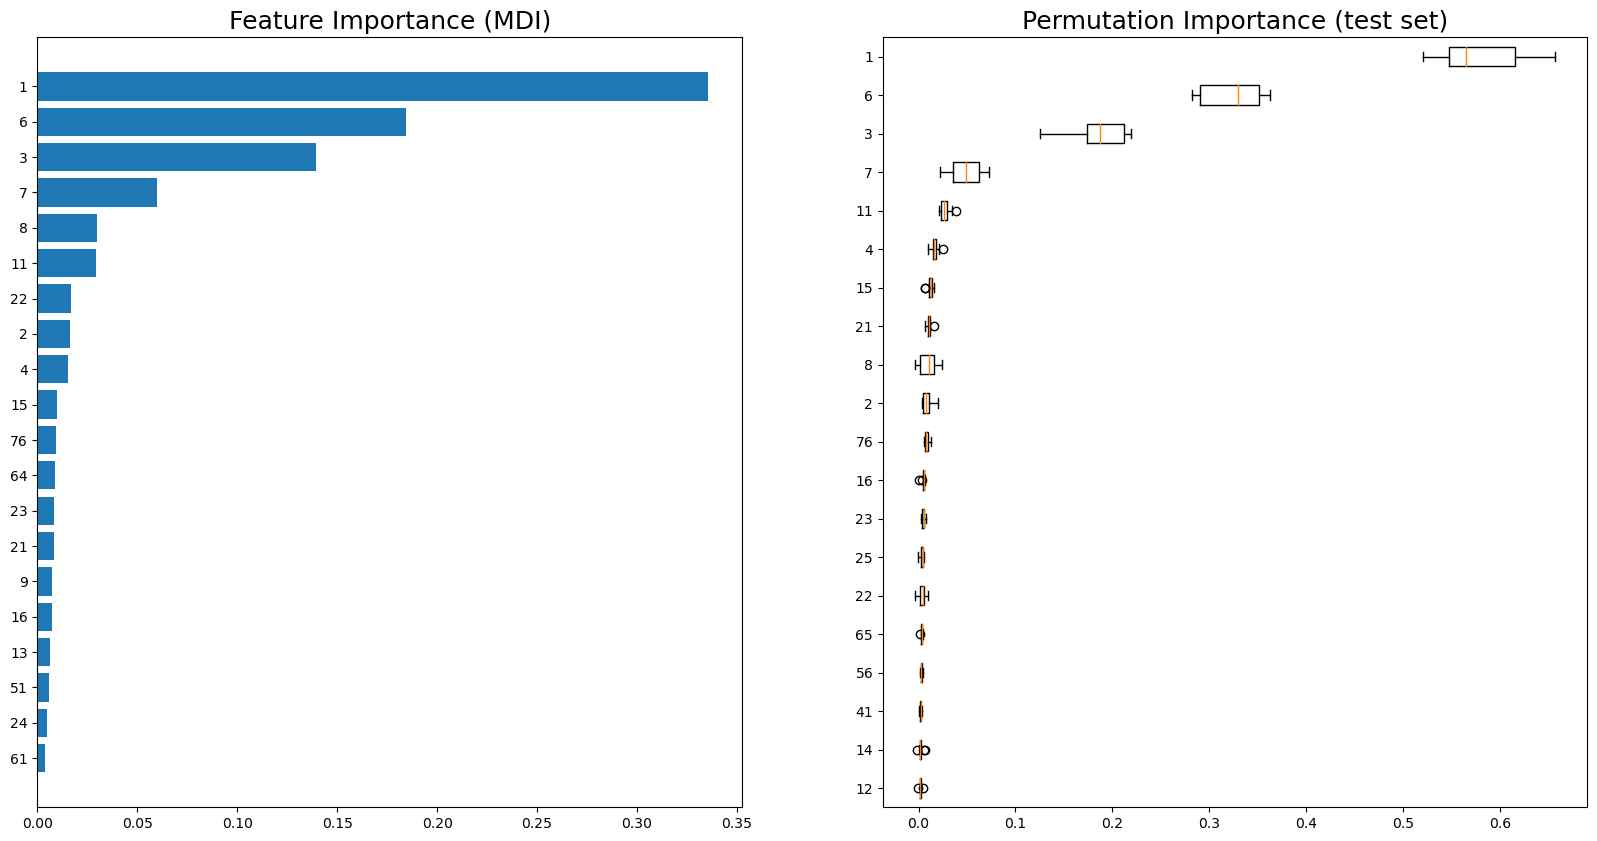

Data comparison is   --   BIAS: -0.01, SI: 0.57, Relative - RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.80, 0.63)
 R score: 0.63 -- in TEST data


 -- METRICS -- 

 {'bias': -0.008002527943401424, 'si': 0.5688119728522942, 'rmse': 0.071512099349321, 'rel_rmse': 0.3066062817299005, 'pearson': 0.7970019001321746, 'rscore': 0.6250330604928123, 'ext_rmse': 0.0955808787235876, 'ext_pearson': 0.38476507644777747} 

 obtained with GradientBoostingRegressor(max_depth=7, min_samples_split=0.08875000000000001,
                          n_estimators=40) !!


In [11]:
# xgboost regression in green island
ss_green = load_private_tgs().sel(name='Green_Is').resample(time='1D').max()
stats_green, green_model, pcs_to_use_green = XGBoost_Regression(
    pcs_cfsr, ss_green, plot_results=True, verbose=True,
    percentage_PCs=0.8, train_size=0.8, xgboost_parameters=None
)
print(f'\n\n -- METRICS -- \n\n {stats_green} \n\n obtained with {green_model} !!')

## XGBoost regression with local predictor

In the following cell, a xgboost regression is performed over all the domain of the Moana v2 hindcast nearshore, having the local pcs (slp + gradient) as the predictor. Moreover, we plot the obtained results, which are also saved in our `data/statistics` folder, with the name `stats_xgboost_local_daily.nc`. Notice that, with the regional predictor, which involves an area of 4 $\cdot$ 4 degrees, we are able to cover just a smaller area, but centered at the location of the virtual moana node.

```{note}
As it can be seen in the results plot, the different shores in New Zealand show very different results, as it could be seen with the regional predictor
```

In [12]:
run = False
if run:
    # perform the XGBoost-Regression (local)
    metrics_local = [] # save local metrics
    pcs_to_use_local = [] # save used pcs 
    sites_local = np.arange(
        0,len(load_cfsr_moana_uhslc.predictand.site.values),1
    ) # select here the desired sites to apply xgboost reg
    # perform the XGBoost regression over all the sites
    for site in progressbar.progressbar(sites_local):
        ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=site)\
            .load().resample(time='1D').max()
        metrics, model, pcs_to_use = XGBoost_Regression(
            PCA_DynamicPred(
                load_cfsr_moana_uhslc.predictor_slp, 
                calculate_gradient=True, time_lapse=3,
                region=(True, (
                    ss_moana.lon.values[0]-2.2,
                    ss_moana.lon.values[0]+2.2,
                    ss_moana.lat.values[0]+2.2,
                    ss_moana.lat.values[0]-2.2
                )),
                pca_plot=(False,False,1), verbose=False
            )[0],
            ss_moana, percentage_PCs=0.999, plot_results=False, verbose=False
        ) # using the local-pre-loaded pcs
        metrics_local.append(list(metrics.values())) # save site metrics
        pcs_to_use_local.append(pcs_to_use) # save used pcs
    # now, save all in xarray.Dataset
    sites_metrics_local = {}
    for im,metric in enumerate(metrics.keys()):
        sites_metrics_local[metric] = (('station'),np.array(metrics_local)[:,im])
    sites_metrics_local['latitude'] = (
        ('station'),load_cfsr_moana_uhslc.predictand.sel(site=sites_local).lat.values
    )
    sites_metrics_local['longitude'] = (
        ('station'),load_cfsr_moana_uhslc.predictand.sel(site=sites_local).lon.values
    )
    # save the metrics
    metrics_dataset_local = xr.Dataset(
        sites_metrics_local,coords={'station':sites_local}
    )
    # local copys
    if False:
        metrics_dataset_local.to_netcdf(
            data_path+'/statistics/models/stats_xgboost_local_daily_new.nc'
        ) # save metrics in all the stations
        np.save(
            data_path+'/statistics/models/pcs_xgboost_local_daily_new.npy',
            np.array(pcs_to_use_local)
        ) # save pcs used in the linear regressions
else:
    metrics_dataset_local = xr.open_dataset(
        data_path+'/statistics/models/stats_xgboost_local_daily.nc'
    )

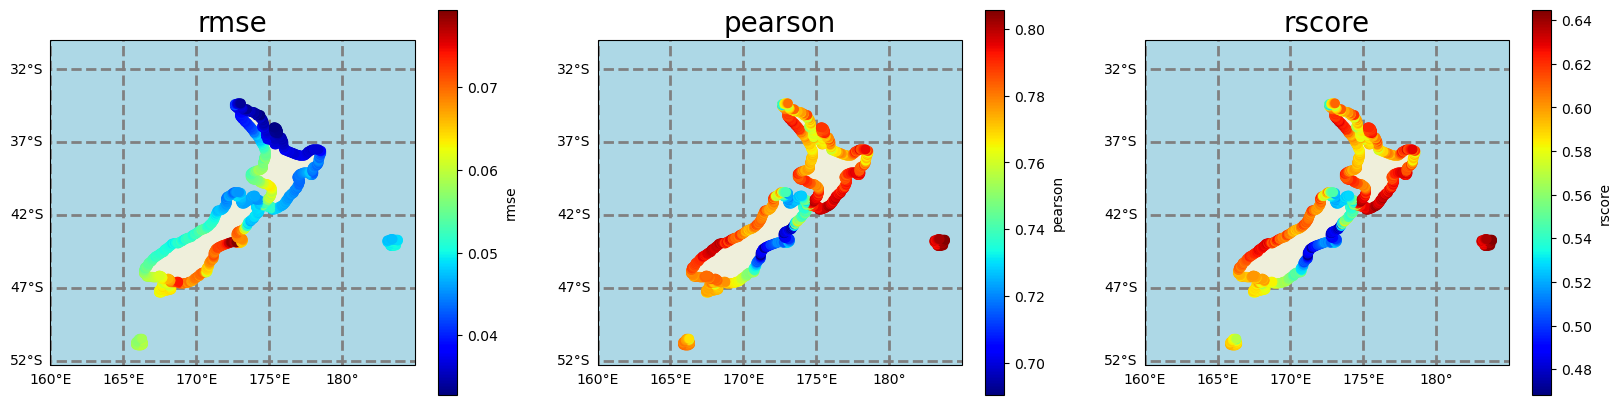

In [13]:
# plot results
if True:
    from sscode.plotting.validation import plot_stats
    plot_stats(metrics_dataset_local,plot_stats=['rmse','pearson','rscore'])

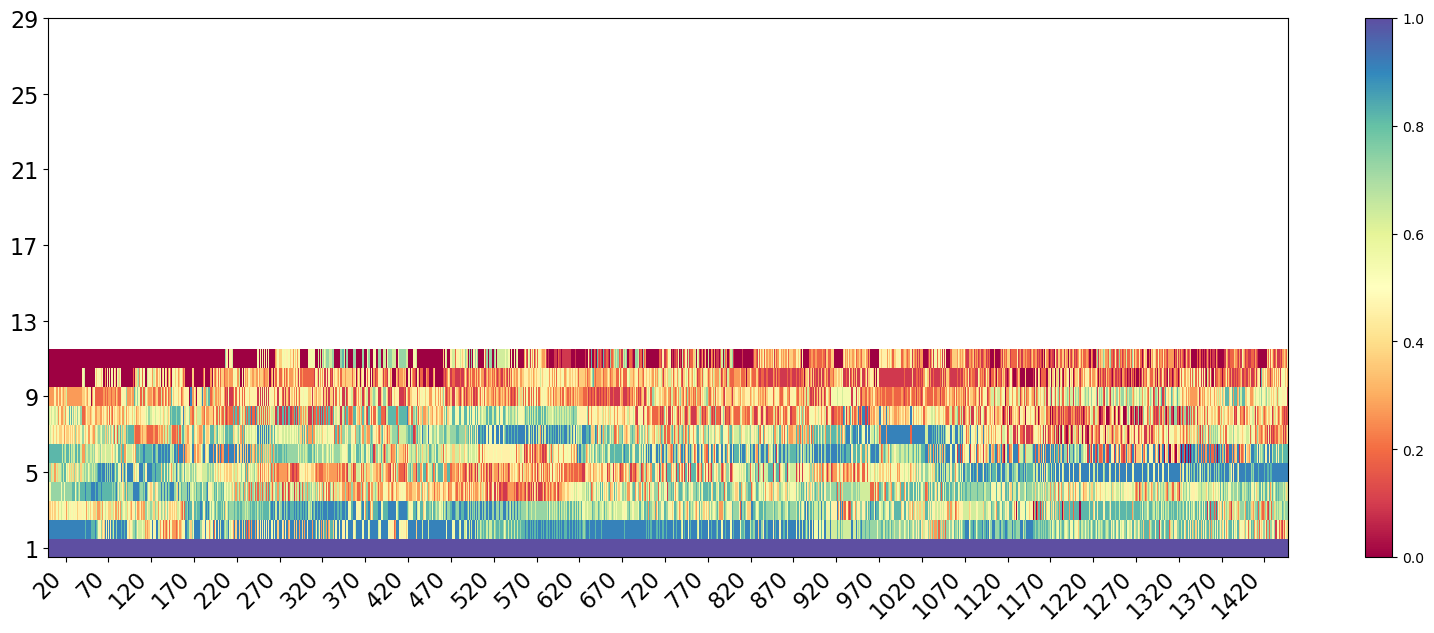

In [14]:
pcs_to_use_local = np.load(
    data_path+'/statistics/models/pcs_xgboost_local_daily.npy',
    allow_pickle=True
)
max_pcs = max([np.max(array) for array in pcs_to_use_local])
pcs_importance = np.zeros((len(pcs_to_use_local),max_pcs))
for i,array in enumerate(pcs_to_use_local):
    for pc in range(max_pcs):
        try:
            pcs_importance[i,pc] = (max_pcs-np.where(array[::-1]==pc)[0])/max_pcs
        except:
            continue
fig, ax = plt.subplots(figsize=(20,7))
pcol = ax.pcolor(pcs_importance.T[:30,:],cmap='Spectral')
fig.colorbar(pcol)
ax.set_yticks(np.arange(0,30,4)+0.5)
ax.set_yticklabels(np.arange(0,30,4)+1,fontsize=16)
ax.set_xticks(np.arange(20,len(pcs_to_use_regional))[::50]+0.5)
ax.set_xticklabels(np.arange(
    20,len(load_cfsr_moana_uhslc.predictand.site.values),1
)[::50],fontsize=16)
plt.setp(ax.get_xticklabels(),rotation=45,ha='right')
plt.show()